In [1]:
import pandas as pd
import numpy as np
import csv
from scipy.stats import pearsonr
from scipy.stats import ConstantInputWarning
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

### Get and prep the data

In [2]:
area = 'pfdl' # pfp

In [3]:
#results_folder = 'Q:\\Personal\\Irina\\projects\\isttc\\results\\monkey\\'
results_folder = 'D:\\projects_q_30_10_2024\\isttc\\results\\monkey\\'
save_folder = results_folder + 'fixation_period_1000ms\\binned\\' + area + '\\acf\\'
#results_folder = 'D:\\projects_q_30_10_2024\\isttc\\results\\monkey\\'

csv_data_file_pfdl = results_folder + 'data_' + area + '_fixon_1500ms_fixation_binned_50ms.csv'
with open(csv_data_file_pfdl, newline='') as f:
    reader = csv.reader(f)
    sua_list_pfdl = list(reader)
    
n_spike_trains_pfdl = len(sua_list_pfdl)
print('N spike_trains in {} fixON {}'.format(area, n_spike_trains_pfdl))

# transform list to an array and to a dataframe 
sua_array_pfdl = np.array(sua_list_pfdl)
print(sua_array_pfdl.shape)

# for 1000 calc
sua_array_pfdl = sua_array_pfdl[:, :-1-9]
print(sua_array_pfdl.shape)

bin_cols = ['bin_' + str(i) for i in range(sua_array_pfdl.shape[1]-3)]
sua_pfdl_df = pd.DataFrame(sua_array_pfdl, columns=['unit_id', 'trial_id','condition_id'] + bin_cols)
sua_pfdl_df = sua_pfdl_df.astype('int')
print(len(sua_pfdl_df))

n_units = len(sua_pfdl_df['unit_id'].unique())
print('n units {}'.format(n_units))

# average unit activity across trails and conditions
unit_average_df = sua_pfdl_df.groupby(by='unit_id', as_index=False)[bin_cols].mean()
print(len(unit_average_df))

N spike_trains in pfdl fixON 33018
(33018, 33)
(33018, 23)
33018
n units 543
543


In [ ]:
sua_pfdl_df

#### Apply contstraints to dataset

1. at least 20 completed trials
2. at least 1hz of mean activity during the fixation period
3. each 50-ms time bin during fixation with nonzero mean activity

In [ ]:
# at least 20 completed trials
unit_trial_count_df = sua_pfdl_df.groupby(by='unit_id', as_index=False)['trial_id'].count()
unit_trial_count_df.rename(columns={'trial_id':'n_trials'}, inplace=True)
unit_trial_count_more20_df = unit_trial_count_df.query('n_trials >= 20').copy()
n_units_trials_20 = len(unit_trial_count_more20_df)
units_trials_20 = unit_trial_count_more20_df['unit_id'].values
#unit_trial_count_more20_df

sua_pfdl_trials_20_df = sua_pfdl_df[sua_pfdl_df['unit_id'].isin(units_trials_20)].copy()
print(len(sua_pfdl_trials_20_df['unit_id'].unique()))

In [ ]:
# each 50-ms time bin during fixation with nonzero mean activity
trial_mean_activity_df = sua_pfdl_trials_20_df.groupby(by='unit_id', as_index=False)[bin_cols].mean()

# n rows with nans
n_nans_trial_mean_activity_df = trial_mean_activity_df.isna().any(axis=1).sum()
print('n rows with nans {}'.format(n_nans_trial_mean_activity_df))

# n rows with 0
rows_without_0_unit_id_l = trial_mean_activity_df[(trial_mean_activity_df[bin_cols].values != 0).all(axis=1)]['unit_id'].values.tolist()
n_units_without_0_bins = len(rows_without_0_unit_id_l)
print('n rows without 0 bins {}'.format(n_units_without_0_bins))

sua_pfdl_trials_20_no_0_bins_df = sua_pfdl_trials_20_df[sua_pfdl_trials_20_df['unit_id'].isin(rows_without_0_unit_id_l)].copy()
print(len(sua_pfdl_trials_20_no_0_bins_df['unit_id'].unique()))

In [ ]:
# at least 1hz of mean activity during the fixation period
trials_20_no_0_bins_mean_activity_df = sua_pfdl_trials_20_no_0_bins_df.groupby(by='unit_id', as_index=False)[bin_cols].mean()
trials_20_no_0_bins_mean_activity_df['bins_sum'] = trials_20_no_0_bins_mean_activity_df[bin_cols].sum(axis=1)
trials_20_no_0_bins_mean_activity_df['fr_hz'] = trials_20_no_0_bins_mean_activity_df['bins_sum']/1.5 # 1500ms
units_more_1hz_l = trials_20_no_0_bins_mean_activity_df.query('fr_hz >= 1')['unit_id'].values
n_units_more_1hz_l = len(units_more_1hz_l)

sua_pfdl_trials_20_no_0_bins_1hz_df = sua_pfdl_trials_20_no_0_bins_df[sua_pfdl_trials_20_no_0_bins_df['unit_id'].isin(units_more_1hz_l)].copy()
print(len(sua_pfdl_trials_20_no_0_bins_1hz_df['unit_id'].unique()))

In [ ]:
print('After first constraint: {}'.format(n_units_trials_20))
print('After second constraint: {}'.format(n_units_without_0_bins))
print('After third constraint: {}'.format(n_units_more_1hz_l))

In [ ]:
# todo THIS is temp here!
pfp_constrained_data_acf_binned_1000_df = sua_pfdl_df.groupby(by='unit_id', as_index=False)['trial_id'].count()
pfp_constrained_data_acf_binned_1000_df.rename(columns={'trial_id':'n_trials'}, inplace=True)
pfp_constrained_data_acf_binned_1000_df['n_trials_more_20'] = pfp_constrained_data_acf_binned_1000_df['n_trials'] >= 20


# each 50-ms time bin during fixation with nonzero mean activity
trial_mean_activity_df = sua_pfdl_df.groupby(by='unit_id', as_index=False)[bin_cols].mean()

# n rows with nans
n_nans_trial_mean_activity_df = trial_mean_activity_df.isna().any(axis=1).sum()
print('n rows with nans {}'.format(n_nans_trial_mean_activity_df))

# n rows with 0
rows_without_0_unit_id_l = trial_mean_activity_df[(trial_mean_activity_df[bin_cols].values != 0).all(axis=1)]['unit_id'].values.tolist()
n_units_without_0_bins = len(rows_without_0_unit_id_l)
print('n rows without 0 bins {}'.format(n_units_without_0_bins))

non_zero_df = pd.DataFrame(np.vstack((rows_without_0_unit_id_l, np.ones(len(rows_without_0_unit_id_l)))).T.astype(int), 
                           columns=['unit_id', 'no_zero_bins'])
pfp_constrained_data_acf_binned_1000_df = pfp_constrained_data_acf_binned_1000_df.merge(non_zero_df, on='unit_id', how='left')
pfp_constrained_data_acf_binned_1000_df['no_zero_bins'] = pfp_constrained_data_acf_binned_1000_df['no_zero_bins'].fillna(value=0).astype(int)
pfp_constrained_data_acf_binned_1000_df

# at least 1hz of mean activity during the fixation period
trials_20_no_0_bins_mean_activity_df = sua_pfdl_df.groupby(by='unit_id', as_index=False)[bin_cols].mean()
trials_20_no_0_bins_mean_activity_df['bins_sum'] = trials_20_no_0_bins_mean_activity_df[bin_cols].sum(axis=1)
trials_20_no_0_bins_mean_activity_df['fr_hz'] = trials_20_no_0_bins_mean_activity_df['bins_sum']/1.5 # 1500ms
units_more_1hz_l = trials_20_no_0_bins_mean_activity_df.query('fr_hz >= 1')['unit_id'].values

one_hz_df = pd.DataFrame(np.vstack((units_more_1hz_l, np.ones(len(units_more_1hz_l)))).T.astype(int), 
                           columns=['unit_id', 'one_hz_activity'])
pfp_constrained_data_acf_binned_1000_df = pfp_constrained_data_acf_binned_1000_df.merge(one_hz_df, on='unit_id', how='left')
pfp_constrained_data_acf_binned_1000_df['one_hz_activity'] = pfp_constrained_data_acf_binned_1000_df['one_hz_activity'].fillna(value=0).astype(int)
pfp_constrained_data_acf_binned_1000_df

pfp_constrained_data_acf_binned_1000_df.to_pickle(results_folder + 'fixation_period_1000ms\\pfdl_constrained_data_acf_binned_1000_df.pkl')
print(len(pfp_constrained_data_acf_binned_1000_df))

### Calculate autocorrelation

In [4]:
def autocorr_pearsonr(signal_, lag_=1, verbose=True):
    # autocorrelation for 1 lag, using pearsonr from scipy
    if verbose:
        print('Calc for lag {}, input length {}'.format(lag_, signal_.shape))
    with warnings.catch_warnings():
        warnings.filterwarnings('error')
        try:
            r, p = pearsonr(signal_[lag_:], signal_[:-lag_])
        except ConstantInputWarning as e:
            print('ERROR: Pearson r can not be calculated for lag {}'.format(lag_))
            r = np.nan
    if verbose:
        print('ac_lag {}'.format(r))
    return r  

def acf_pearsonr(signal_, nlags=2, verbose=True):
    acf = [1] 
    for i in range(1, nlags): # todo why I had here nlags+1?
        acf.append(autocorr_pearsonr(signal_, i, verbose)) 
    return np.array(acf)

def acf_pearsonr_trial_avg(trials_time_series_2d, nlags_, verbose=True):
    time_series_a = trials_time_series_2d[:, :nlags_]
    nbins = time_series_a.shape[1]
    if verbose:
        print('nbins to use {}'.format(nbins))
    acf_matrix = np.zeros((nbins, nbins))

    for i in np.arange(nbins-1):
        for j in np.arange(i+1, nbins): # filling i-th row
            with warnings.catch_warnings():
                warnings.filterwarnings('error')
                try:
                    r, p = pearsonr(time_series_a[:,i], time_series_a[:,j]) 
                    acf_matrix[i, j] = r
                except ConstantInputWarning as e:
                    print('ERROR: Pearson r can not be calculated for i={}, j={}'.format(i,j))
                    acf_matrix[i, j] = np.nan
            
    np.fill_diagonal(acf_matrix, 1)
            
    acf_average = np.zeros((nbins,))
    for i in range(nbins):
        with warnings.catch_warnings():
            warnings.filterwarnings('error')
            try:
                acf_average[i] = np.nanmean(np.diag(acf_matrix, k=i))
            except RuntimeWarning as e:
                print('ERROR: Mean can not be calculated for lag={}'.format(i), e)
                acf_average[i] = np.nan
                
    return acf_matrix, acf_average

In [5]:
n_lags = 20
acf_cols = ['acf_' + str(i) for i in range(n_lags)]
print('acf_cols {}'.format(acf_cols))

acf_cols ['acf_0', 'acf_1', 'acf_2', 'acf_3', 'acf_4', 'acf_5', 'acf_6', 'acf_7', 'acf_8', 'acf_9', 'acf_10', 'acf_11', 'acf_12', 'acf_13', 'acf_14', 'acf_15', 'acf_16', 'acf_17', 'acf_18', 'acf_19']


In [6]:
# unit_average_df = sua_pfdl_trials_20_no_0_bins_1hz_df.groupby(by='unit_id', as_index=False)[bin_cols].mean()
# sua_pfdl_df = sua_pfdl_trials_20_no_0_bins_1hz_df
unit_average_df = sua_pfdl_df.groupby(by='unit_id', as_index=False)[bin_cols].mean()
#sua_pfdl_df = sua_pfdl_trials_20_no_0_bins_1hz_df

In [ ]:
unit_average_df

#### Calc acf (acf/Pearson) for average over trials and conditions (1 ACF per unit)

In [ ]:
acf_proper_trial_mean_l = []

for unit in range(len(unit_average_df)):
    print('Processing unit {}'.format(unit_average_df['unit_id'].values[unit]))
    # there is nothing to correlated with at lag 20 for 1000ms
    # acf will return 0 because of the formula
    acf_proper_trial_mean = acf(unit_average_df[bin_cols].values[unit, :], nlags=n_lags) 
    acf_proper_trial_mean_l.append(acf_proper_trial_mean)

acf_proper_trial_mean_df = pd.DataFrame(np.array(acf_proper_trial_mean_l), columns=acf_cols)
acf_proper_trial_mean_df.insert(0, 'unit_id', unit_average_df['unit_id'].values)

print('NaNs in acf {}'.format(acf_proper_trial_mean_df.isnull().any().any()))
acf_proper_trial_mean_df.head(3)

In [ ]:
acf_pearsonr_trial_mean_l = []

for unit in range(len(unit_average_df)):
    print('Processing unit {}'.format(unit_average_df['unit_id'].values[unit]))
    acf_pearsonr_trial_mean = acf_pearsonr(unit_average_df[bin_cols].values[unit, :], nlags=n_lags-1, verbose=False) # -2 for calc 1000 todo
    acf_pearsonr_trial_mean_l.append(acf_pearsonr_trial_mean)

acf_pearsonr_trial_mean_df = pd.DataFrame(np.array(acf_pearsonr_trial_mean_l), columns=acf_cols[:-1]) # also for 1000
acf_pearsonr_trial_mean_df.insert(0, 'unit_id', unit_average_df['unit_id'].values)

print('NaNs in acf {}'.format(acf_pearsonr_trial_mean_df.isnull().any().any()))
acf_pearsonr_trial_mean_df.head(3)

In [ ]:
acf_proper_trial_mean_df.to_pickle(save_folder + 'acf_proper_trial_mean_constraint_input_50ms_20lags_df.pkl')
acf_pearsonr_trial_mean_df.to_pickle(save_folder + 'acf_pearsonr_trial_mean_constraint_input_50ms_20lags_df.pkl')

#### Calc acf (acf/Pearson) per trial (multiple ACFs per unit)

In [ ]:
acf_proper_l = []

for idx in range(len(sua_pfdl_df)):
    print('Processing unit {}, trial {}'.format(sua_pfdl_df['unit_id'].values[idx], sua_pfdl_df['trial_id'].values[idx]))
    acf_proper = acf(sua_pfdl_df[bin_cols].values[idx, :], nlags=n_lags)
    acf_proper_l.append(acf_proper)

acf_proper_df = pd.DataFrame(np.array(acf_proper_l), columns=acf_cols)
acf_proper_df.insert(0, 'unit_id', sua_pfdl_df['unit_id'].values)
acf_proper_df.insert(1, 'trial_id', sua_pfdl_df['trial_id'].values)

print('NaNs in acf {}'.format(acf_proper_df.isnull().any().any()))
acf_proper_df.head(3)

In [ ]:
acf_pearsonr_l = []

for idx in range(len(sua_pfdl_df)):
    print('Processing unit {}, trial {}'.format(sua_pfdl_df['unit_id'].values[idx], sua_pfdl_df['trial_id'].values[idx]))
    acf_pearsonr_ = acf_pearsonr(sua_pfdl_df[bin_cols].values[idx, :], nlags=n_lags-1, verbose=False)
    acf_pearsonr_l.append(acf_pearsonr_)

acf_pearsonr_df = pd.DataFrame(np.array(acf_pearsonr_l), columns=acf_cols[:-1])
acf_pearsonr_df.insert(0, 'unit_id', sua_pfdl_df['unit_id'].values)
acf_pearsonr_df.insert(1, 'trial_id', sua_pfdl_df['trial_id'].values)

print('NaNs in acf {}'.format(acf_pearsonr_df.isnull().any().any()))
acf_pearsonr_df.head(3)

In [ ]:
acf_proper_df.to_pickle(save_folder + 'acf_proper_df_constraint_input_50ms_20lags_df.pkl')
acf_pearsonr_df.to_pickle(save_folder + 'acf_pearsonr_df_constraint_input_50ms_20lags_df.pkl')

In [ ]:
# n rows with nans
n_nans_acf_proper_trial_mean_df = acf_proper_trial_mean_df.isna().any(axis=1).sum()
n_nans_acf_pearsonr_trial_mean_df = acf_pearsonr_trial_mean_df.isna().any(axis=1).sum()
n_nans_acf_proper_df = acf_proper_df.isna().any(axis=1).sum()
n_nans_acf_pearsonr_df = acf_pearsonr_df.isna().any(axis=1).sum()

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(10,8), sharey=True)

for acf_ in range(len(acf_proper_trial_mean_df)):
    axes[0,0].plot(acf_proper_trial_mean_df[acf_cols].values[acf_, :], lw=0.5, c='k', alpha=0.1)
axes[0,0].plot(np.nanmean(acf_proper_trial_mean_df[acf_cols].values, axis=0), c='r', lw=0.5 ,marker='o', markersize='5')
axes[0,0].axhline(y=0, lw=0.5, color='k')
axes[0,0].axhline(y=1/np.e, lw=0.5, color='k')
axes[0,0].set_title('acf_proper_trial_mean, num acf = ' + str(len(acf_proper_trial_mean_df)) + '\n with nans ' + str(n_nans_acf_proper_trial_mean_df))

for acf_ in range(len(acf_pearsonr_trial_mean_df)):
    axes[0,1].plot(acf_pearsonr_trial_mean_df[acf_cols[:-1]].values[acf_, :], lw=0.5, c='k', alpha=0.1)
axes[0,1].plot(np.nanmean(acf_pearsonr_trial_mean_df[acf_cols[:-1]].values, axis=0), c='r', lw=0.5 ,marker='o', markersize='5')
axes[0,1].axhline(y=0, lw=0.5, color='k')
axes[0,1].axhline(y=1/np.e, lw=0.5, color='k')
axes[0,1].set_title('acf_pearsonr_trial_mean, num acf = ' + str(len(acf_pearsonr_trial_mean_df)) + '\n with nans ' + str(n_nans_acf_pearsonr_trial_mean_df))

for acf_ in range(len(acf_proper_df)):
    axes[1,0].plot(acf_proper_df[acf_cols].values[acf_, :], lw=0.5, c='k', alpha=0.1)
axes[1,0].plot(np.nanmean(acf_proper_df[acf_cols].values, axis=0), c='r', lw=0.5 ,marker='o', markersize='5')
axes[1,0].axhline(y=0, lw=0.5, color='k')
axes[1,0].set_title('acf_proper, num acf = ' + str(len(acf_proper_df)) + '\n with nans ' + str(n_nans_acf_proper_df))

for acf_ in range(len(acf_pearsonr_df)):
    axes[1,1].plot(acf_pearsonr_df[acf_cols[:-1]].values[acf_, :], lw=0.5, c='k', alpha=0.1)
axes[1,1].plot(np.nanmean(acf_pearsonr_df[acf_cols[:-1]].values, axis=0), c='r', lw=0.5 ,marker='o', markersize='5')
axes[1,1].axhline(y=0, lw=0.5, color='k')
axes[1,1].set_title('acf_pearsonr, num acf = ' + str(len(acf_pearsonr_df)) + '\n with nans ' + str(n_nans_acf_pearsonr_df))

sns.despine()

fig.savefig(save_folder + 'acf_proper_and_pearsonr_constraint_input_50ms_20lags.png' , bbox_inches='tight')

#### Calc acf as in Siegle (they use Pearson) - trial average

In [7]:
acf_average_trial_pearsonr_l = []
acf_matrix_l = []

unit_id_l = sua_pfdl_df['unit_id'].unique()
unit_id_calc_l = []

for unit in unit_id_l:
    print('Processing unit {}'.format(unit))
    sua_pfdl_one_trial_df = sua_pfdl_df.query('unit_id == @unit')
    print('N trials {}'.format(len(sua_pfdl_one_trial_df)))
    if len(sua_pfdl_one_trial_df) <= 1:
        print('ONLY 1 TRIAL: can not calculate, skipping...')
    else:
        acf_matrix, acf_average = acf_pearsonr_trial_avg(sua_pfdl_one_trial_df[bin_cols].values, n_lags)
        acf_average_trial_pearsonr_l.append(acf_average)
        acf_matrix_l.append(acf_matrix)
        unit_id_calc_l.append(unit)

acf_average_trial_pearsonr_df = pd.DataFrame(np.array(acf_average_trial_pearsonr_l), columns=acf_cols)
acf_average_trial_pearsonr_df.insert(0, 'unit_id', unit_id_calc_l)

print('NaNs in acf {}'.format(acf_average_trial_pearsonr_df.isnull().any().any()))
acf_average_trial_pearsonr_df.head(3)

Processing unit 0
N trials 92
nbins to use 20
Processing unit 1
N trials 41
nbins to use 20
ERROR: Pearson r can not be calculated for i=0, j=19
ERROR: Pearson r can not be calculated for i=1, j=19
ERROR: Pearson r can not be calculated for i=2, j=19
ERROR: Pearson r can not be calculated for i=3, j=19
ERROR: Pearson r can not be calculated for i=4, j=19
ERROR: Pearson r can not be calculated for i=5, j=19
ERROR: Pearson r can not be calculated for i=6, j=19
ERROR: Pearson r can not be calculated for i=7, j=19
ERROR: Pearson r can not be calculated for i=8, j=19
ERROR: Pearson r can not be calculated for i=9, j=19
ERROR: Pearson r can not be calculated for i=10, j=19
ERROR: Pearson r can not be calculated for i=11, j=19
ERROR: Pearson r can not be calculated for i=12, j=19
ERROR: Pearson r can not be calculated for i=13, j=19
ERROR: Pearson r can not be calculated for i=14, j=19
ERROR: Pearson r can not be calculated for i=15, j=19
ERROR: Pearson r can not be calculated for i=16, j=19


unit_id  acf_0     acf_1     acf_2     acf_3     acf_4     acf_5     acf_6  \
0        0    1.0  0.443787  0.429808  0.374760  0.333984  0.287734  0.240484   
1        1    1.0  0.005432  0.069626 -0.009532  0.027993  0.051967  0.029365   
2        2    1.0  0.061446  0.036480  0.032609 -0.006591  0.043266  0.069176   

      acf_7     acf_8  ...    acf_10    acf_11    acf_12    acf_13    acf_14  \
0  0.189922  0.194006  ...  0.192847  0.148964  0.216269  0.151006  0.159405   
1  0.119701 -0.058856  ... -0.056264  0.066109 -0.049954  0.124875 -0.049265   
2  0.006825  0.005949  ... -0.016844  0.008550  0.024759 -0.003741  0.000973   

     acf_15    acf_16    acf_17    acf_18    acf_19  
0  0.112679  0.020760  0.038556  0.046108 -0.052432  
1 -0.046850 -0.040645 -0.040116 -0.044426       NaN  
2  0.222765  0.063553 -0.084937  0.094580 -0.113666  

[3 rows x 21 columns]

In [8]:
acf_average_trial_pearsonr_df.to_pickle(save_folder + 'acf_average_trial_pearsonr_50ms_20lags_df.pkl')
np.save(save_folder + 'acf_matrix_l_50ms_20lags_df.npy', acf_matrix_l)

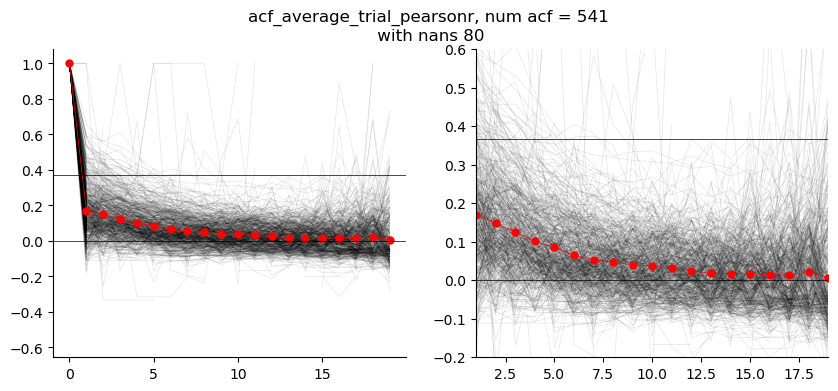

In [9]:
n_nans_acf_average_trial_pearsonr_df= acf_average_trial_pearsonr_df.isna().any(axis=1).sum()

fig, axes = plt.subplots(1,2, figsize=(10,4))

for acf_ in range(len(acf_average_trial_pearsonr_df)):
    axes[0].plot(acf_average_trial_pearsonr_df[acf_cols].values[acf_, :], lw=0.5, c='k', alpha=0.1)
axes[0].plot(np.nanmean(acf_average_trial_pearsonr_df[acf_cols].values, axis=0), c='r', lw=0.5 ,marker='o', markersize='5')
axes[0].axhline(y=0, lw=0.5, color='k')
axes[0].axhline(y=1/np.e, lw=0.5, color='k')

for acf_ in range(len(acf_average_trial_pearsonr_df)):
    axes[1].plot(acf_average_trial_pearsonr_df[acf_cols].values[acf_, :], lw=0.5, c='k', alpha=0.1)
axes[1].plot(np.nanmean(acf_average_trial_pearsonr_df[acf_cols].values, axis=0), c='r', lw=0.5 ,marker='o', markersize='5')
axes[1].axhline(y=0, lw=0.5, color='k')
axes[1].axhline(y=1/np.e, lw=0.5, color='k')
axes[1].set_xlim([1,19])
axes[1].set_ylim([-0.2,0.6])

fig.suptitle('acf_average_trial_pearsonr, num acf = ' + str(len(acf_average_trial_pearsonr_df)) + '\n with nans ' 
             + str(n_nans_acf_average_trial_pearsonr_df))

sns.despine()
fig.savefig(save_folder + 'acf_average_trial_pearsonr_50ms_20lags.png' , bbox_inches='tight')

C:\Users\ipoch\AppData\Local\Temp\ipykernel_18260\2014500534.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1,1,figsize=(6,6))


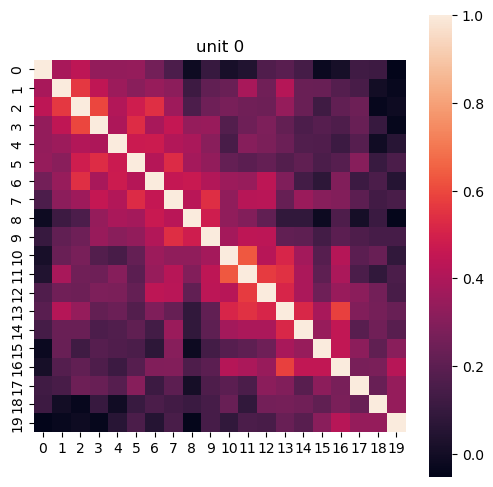

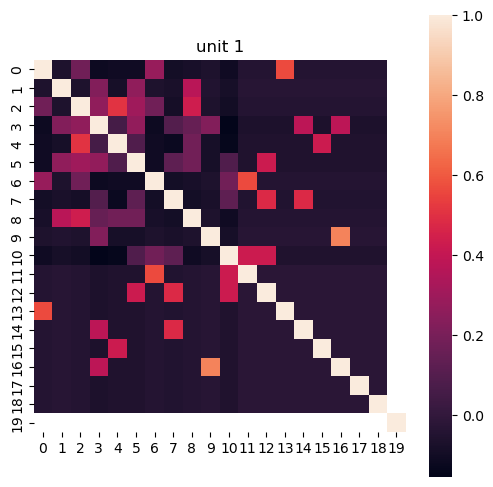

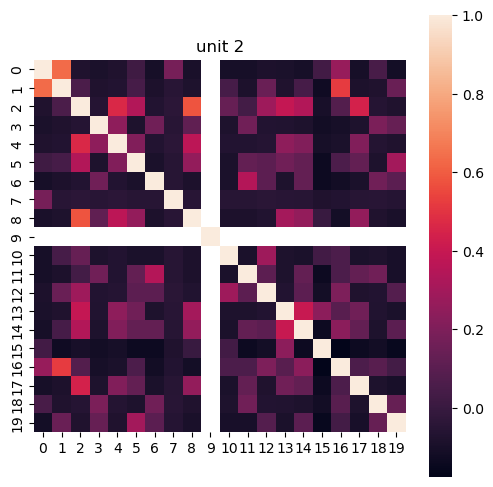

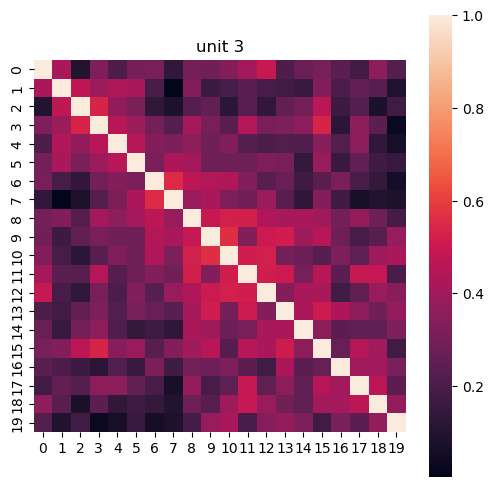

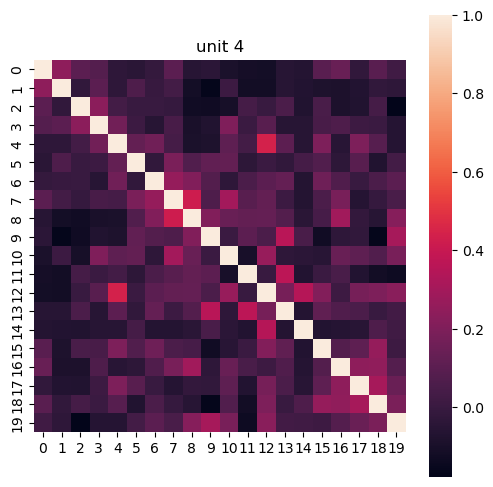

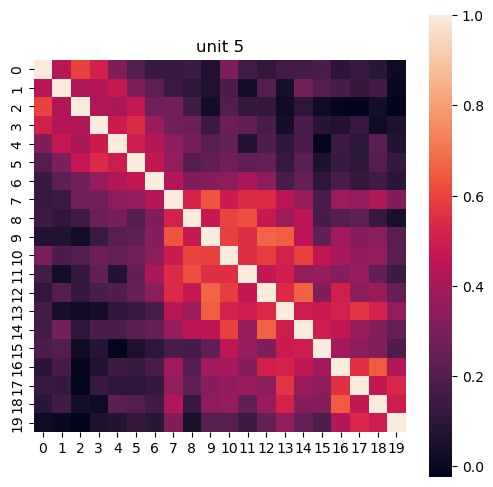

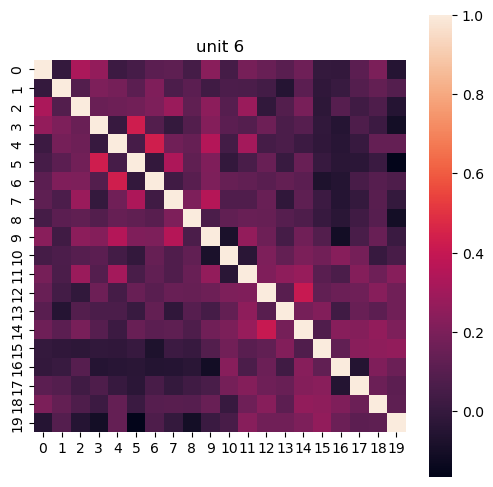

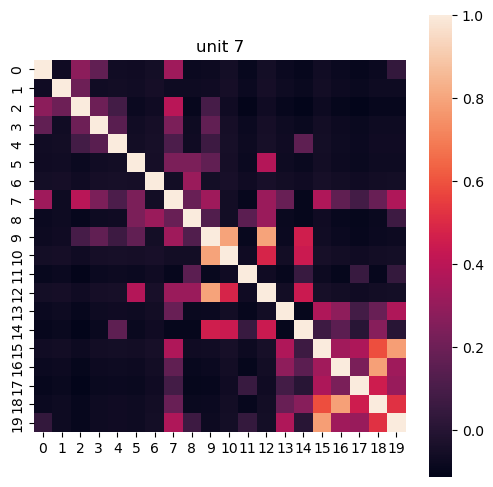

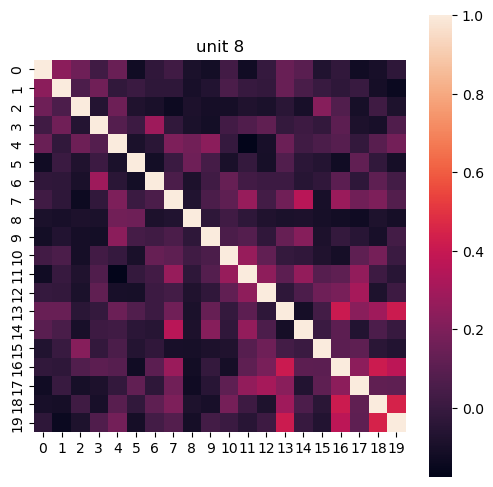

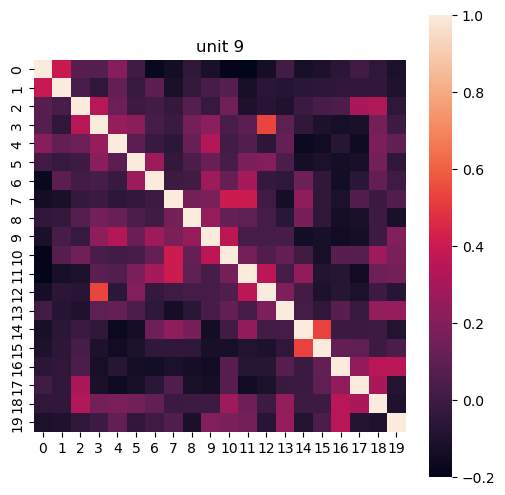

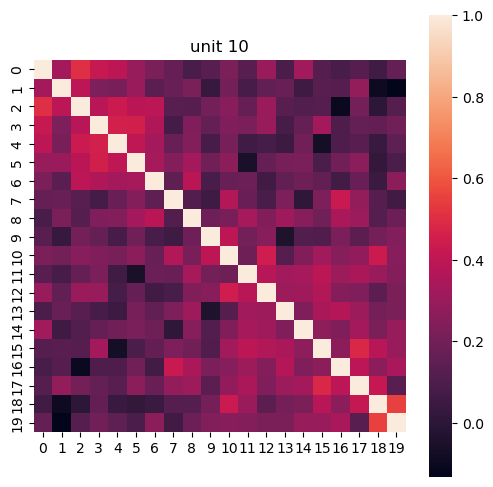

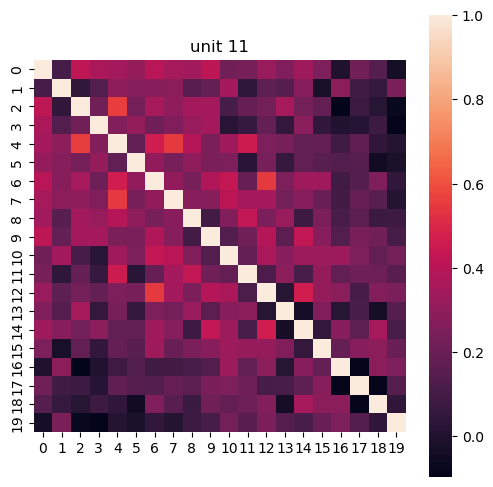

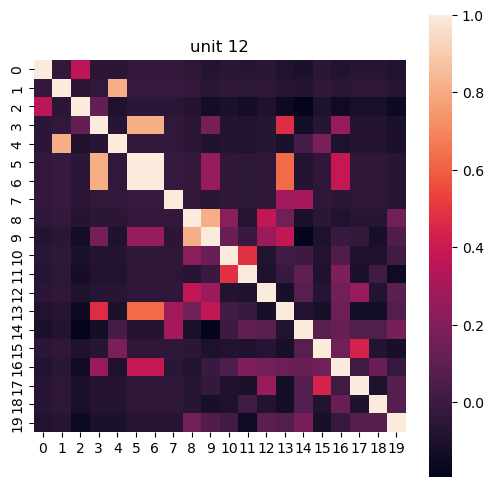

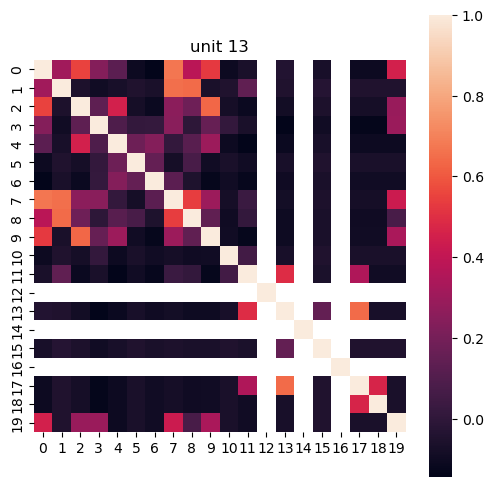

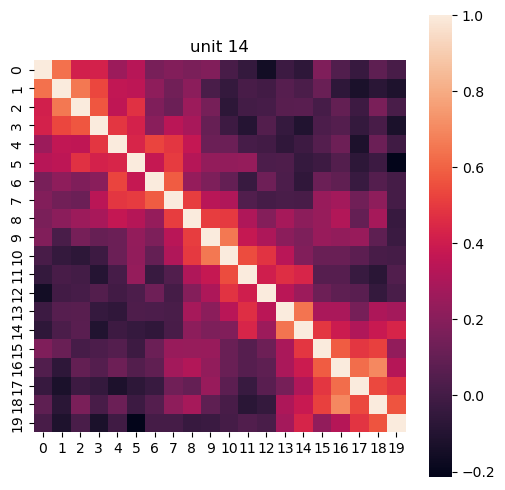

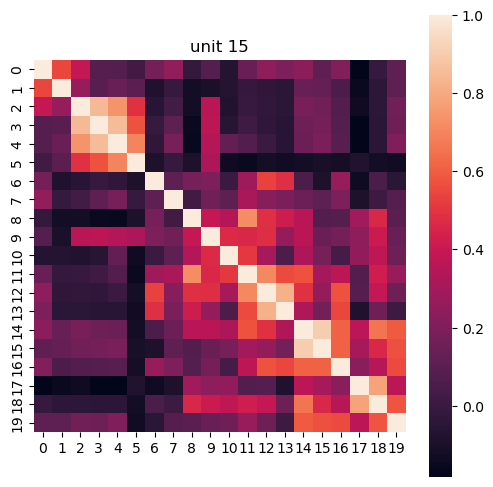

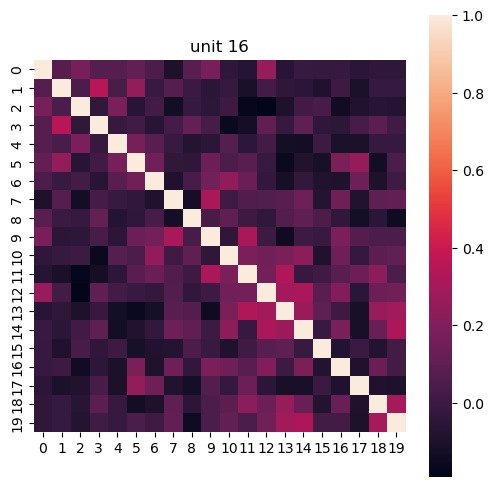

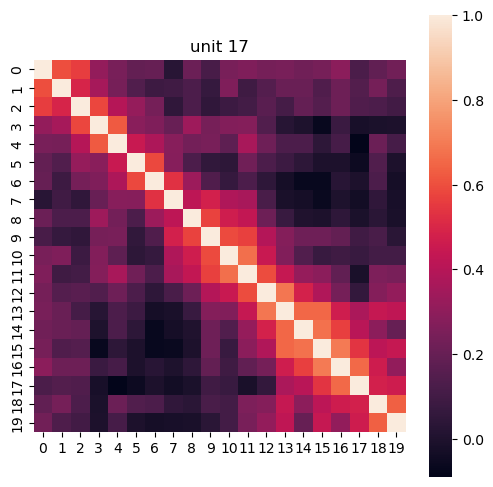

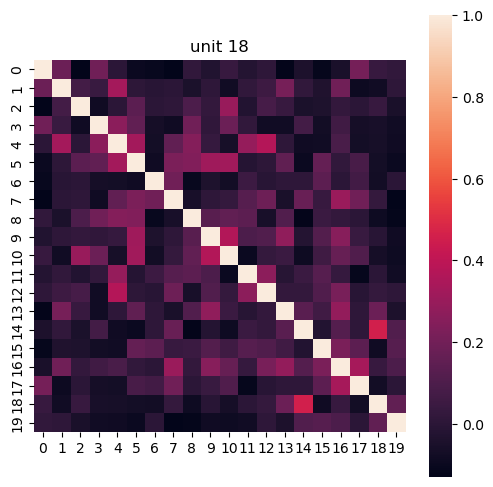

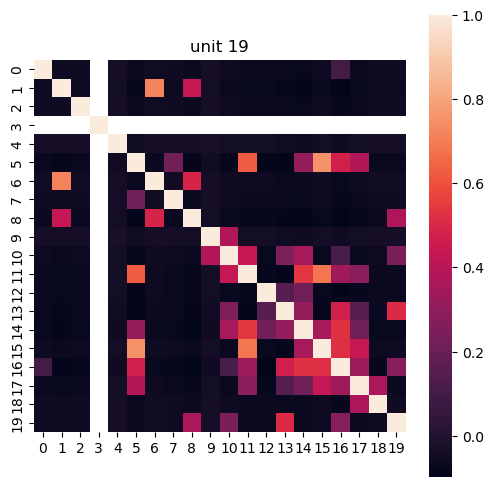

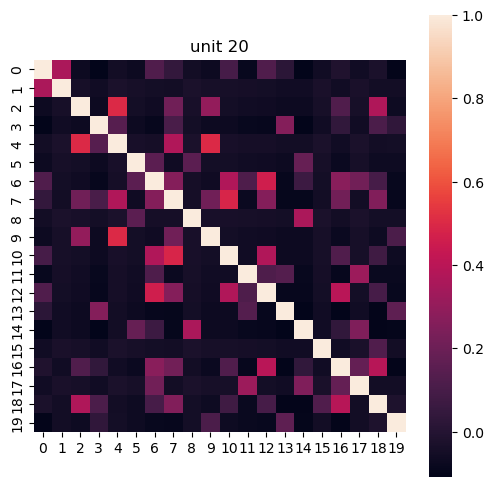

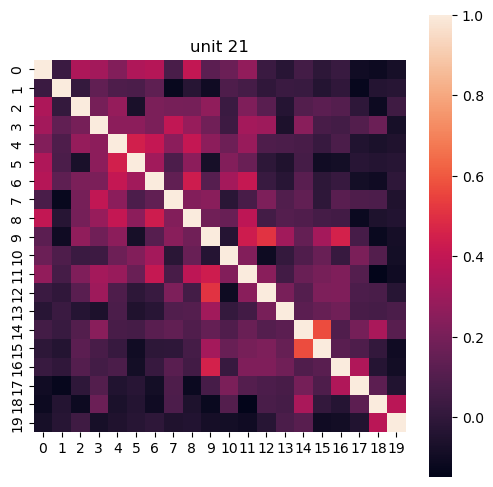

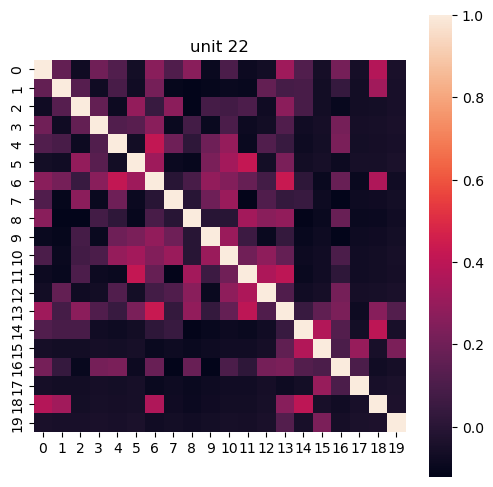

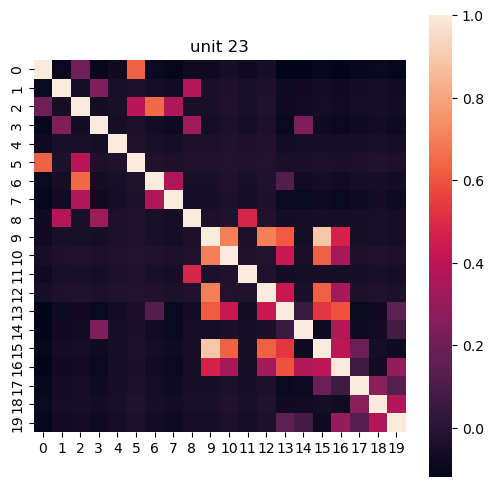

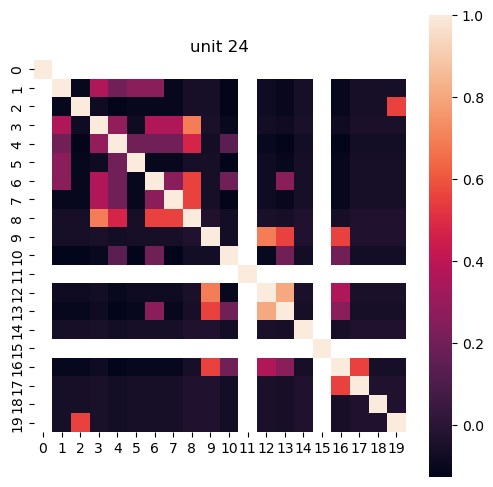

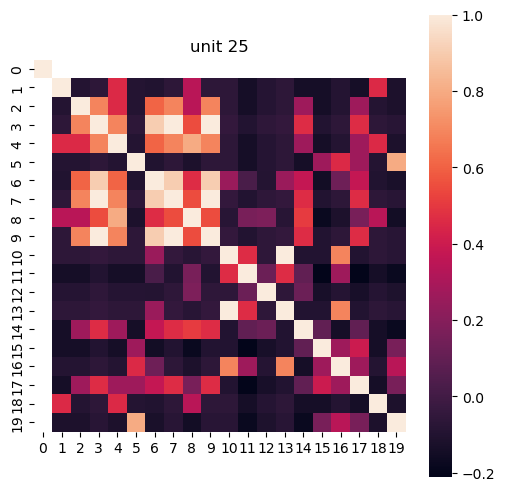

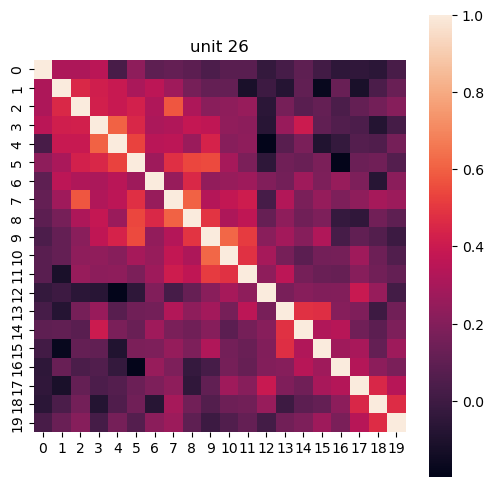

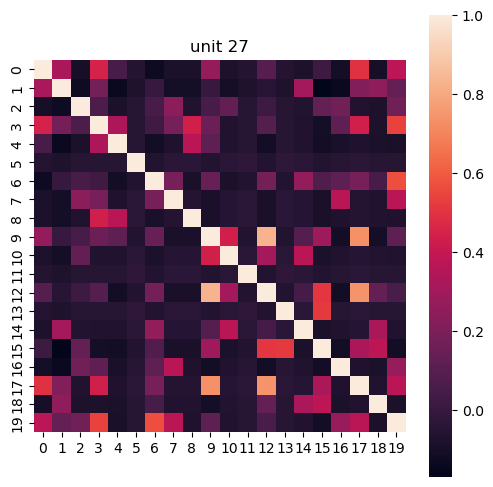

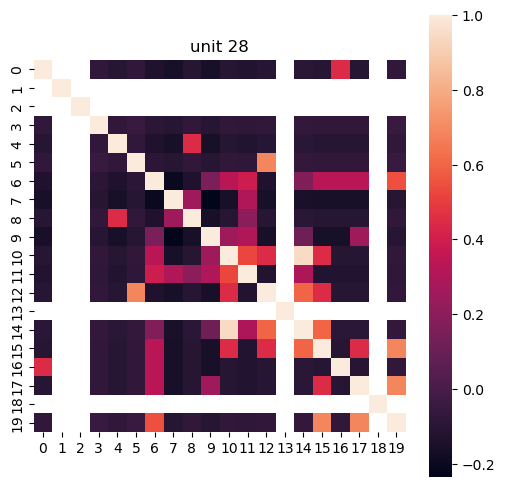

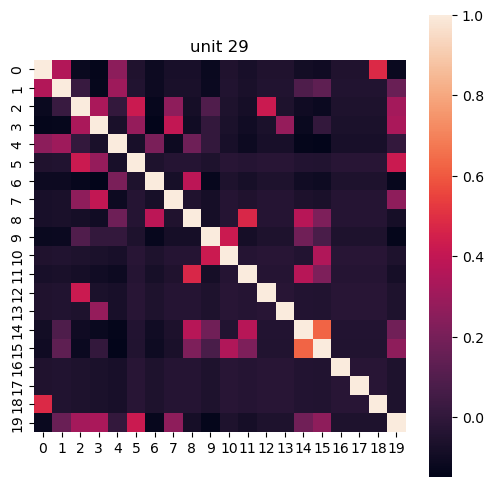

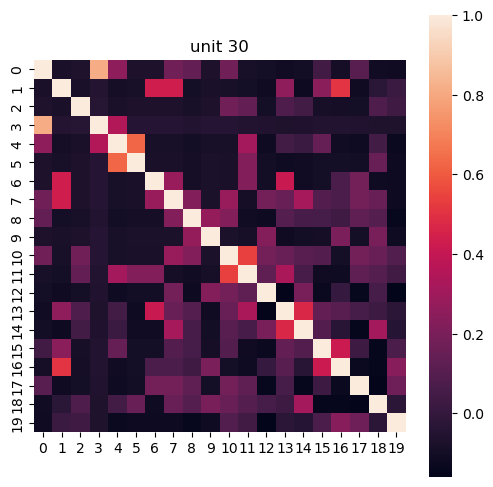

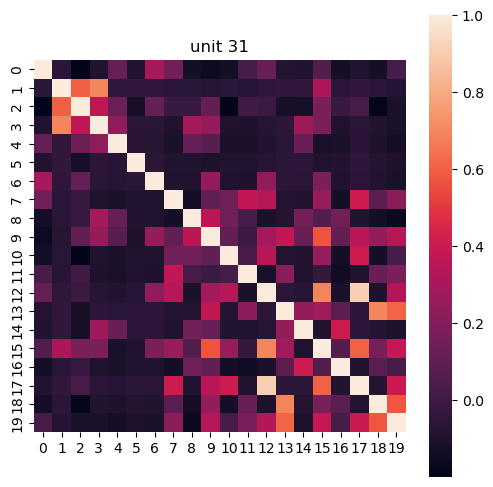

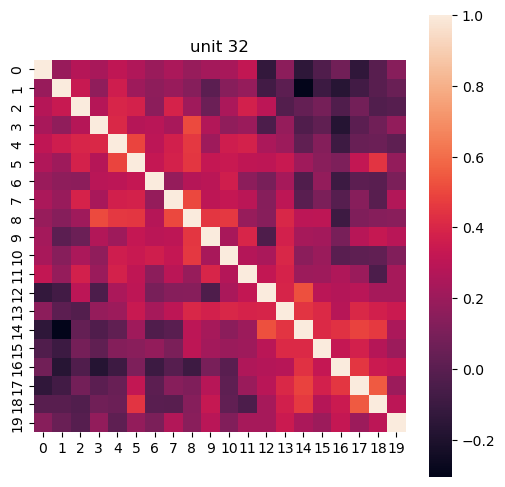

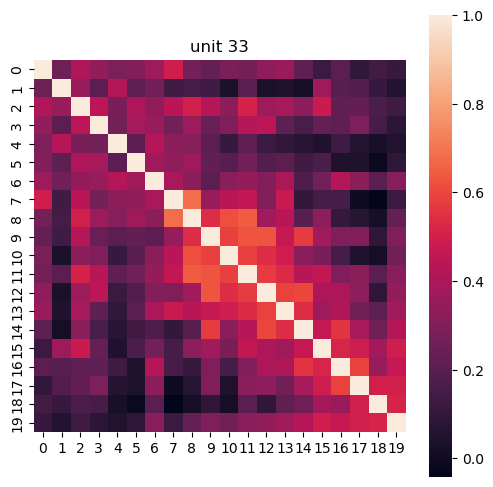

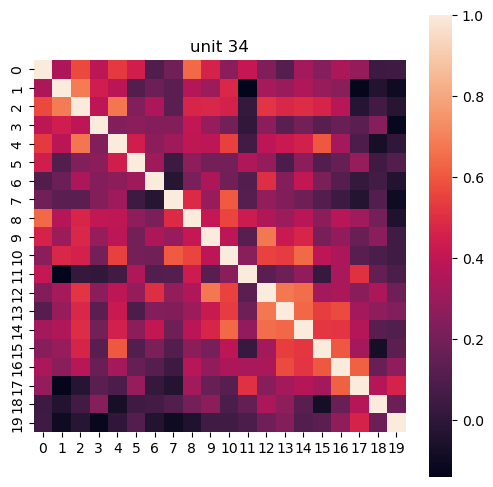

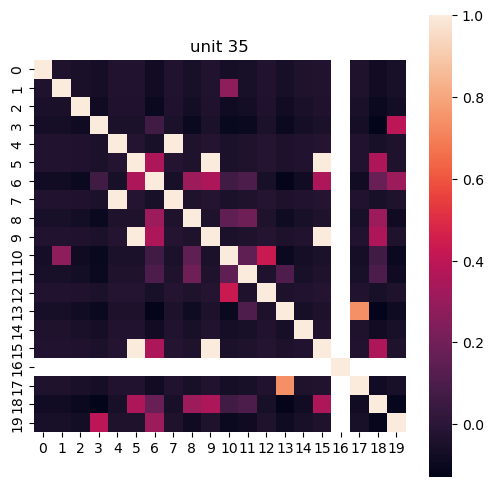

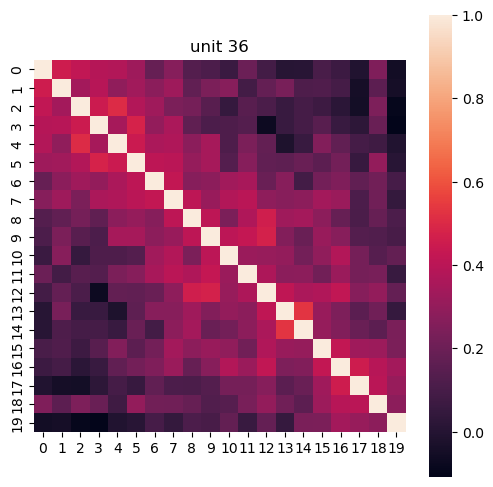

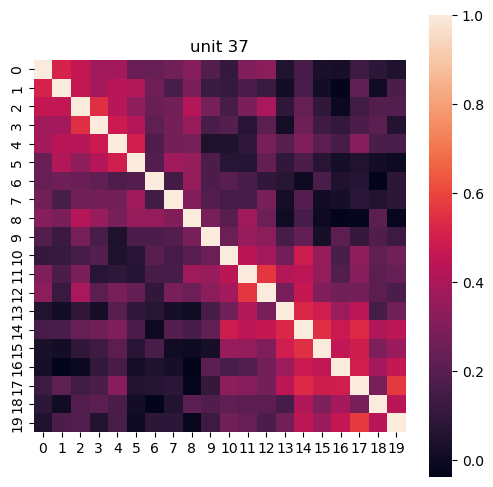

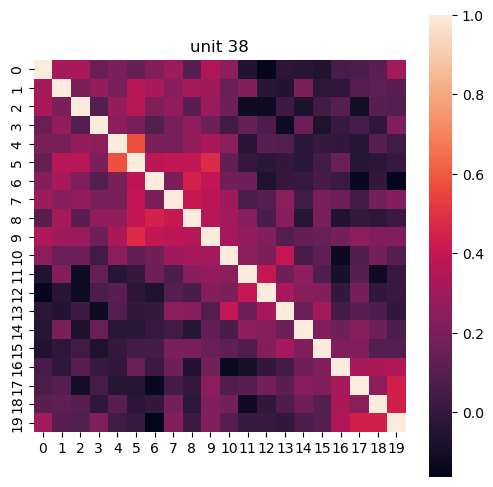

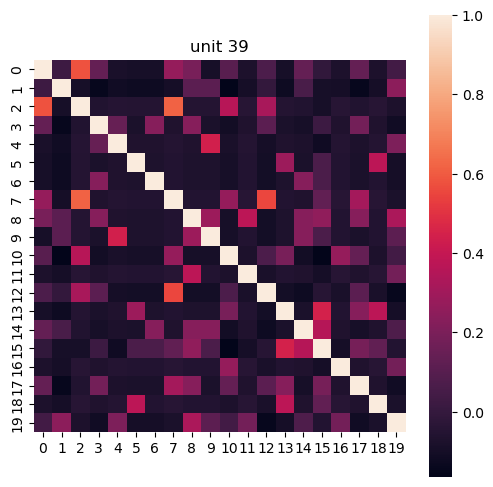

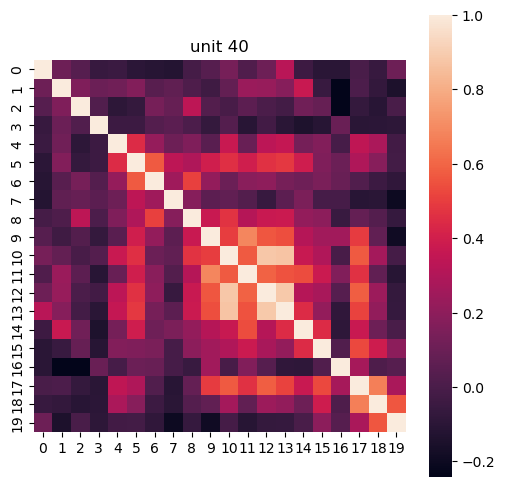

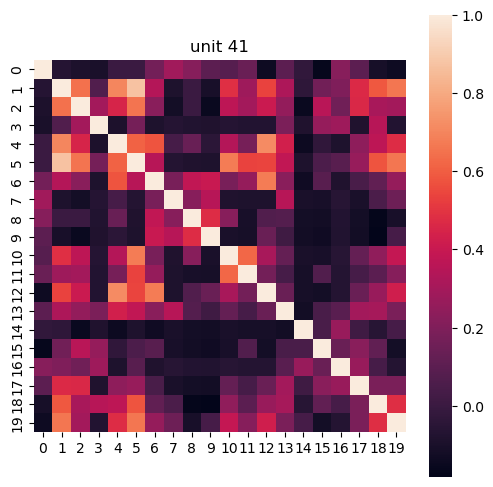

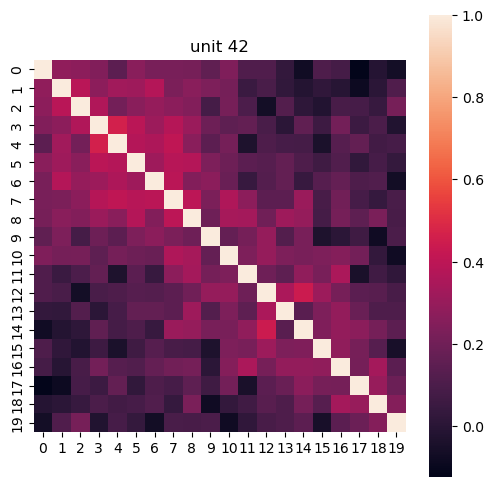

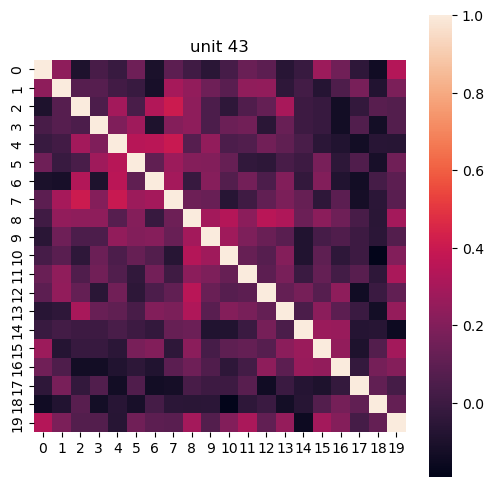

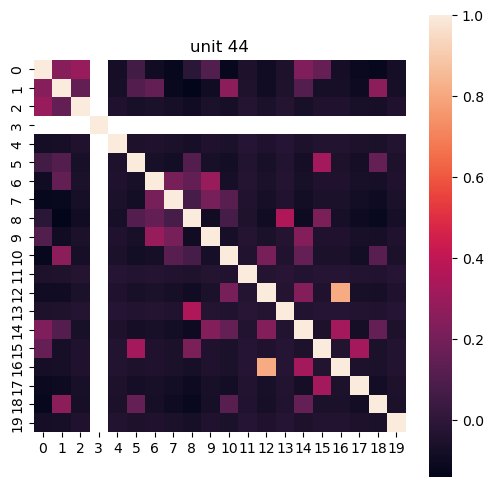

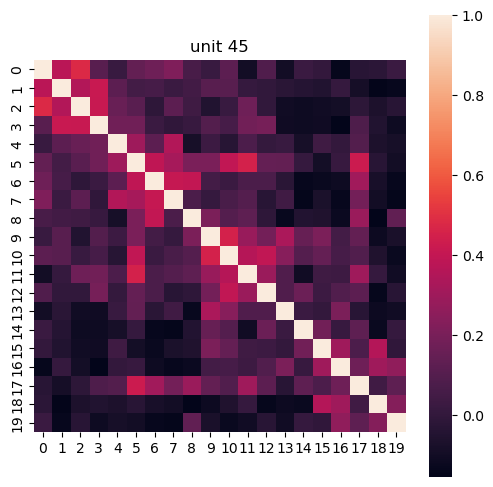

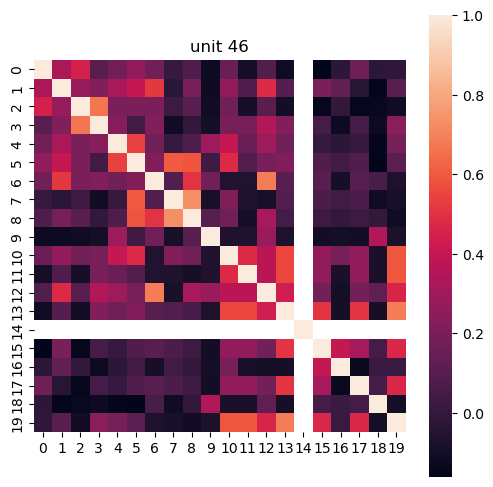

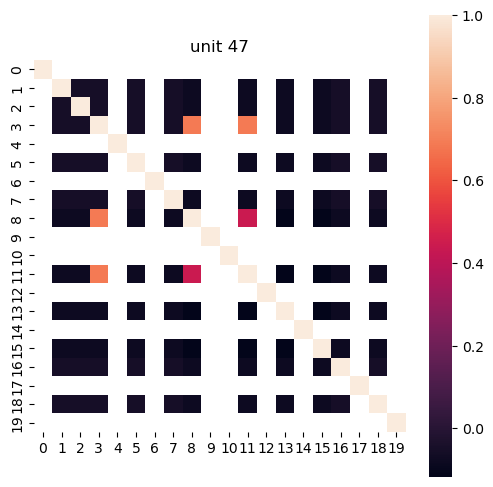

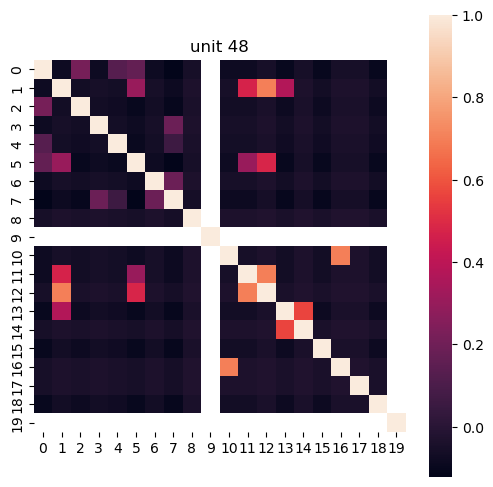

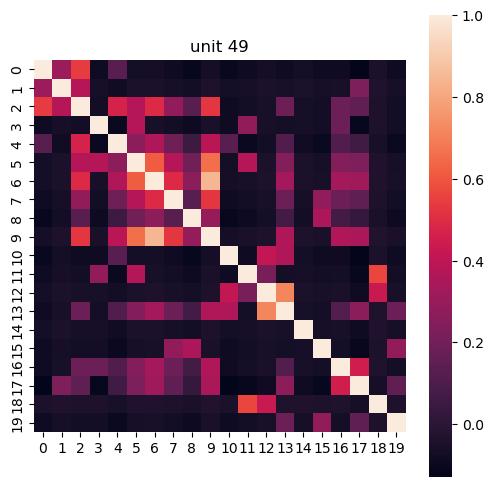

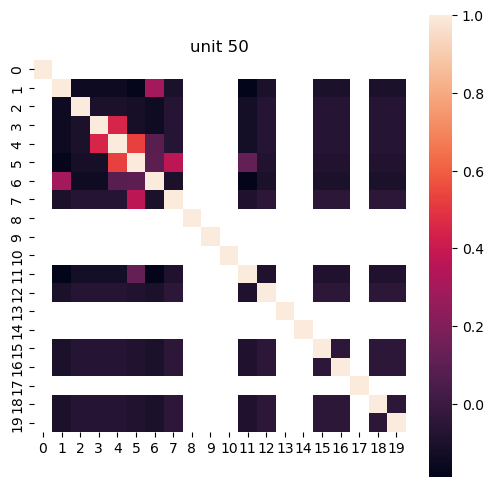

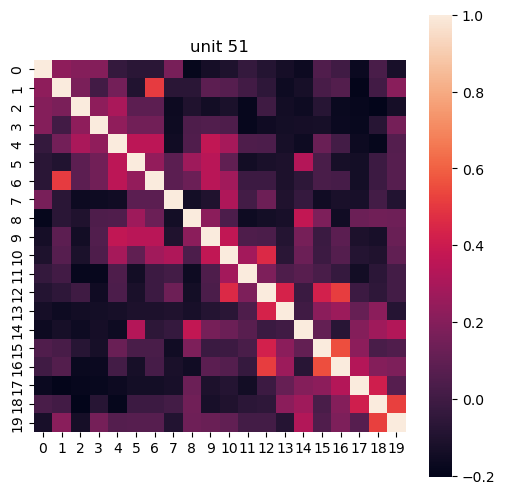

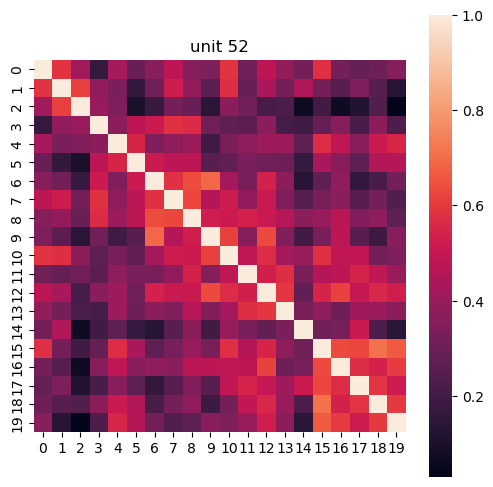

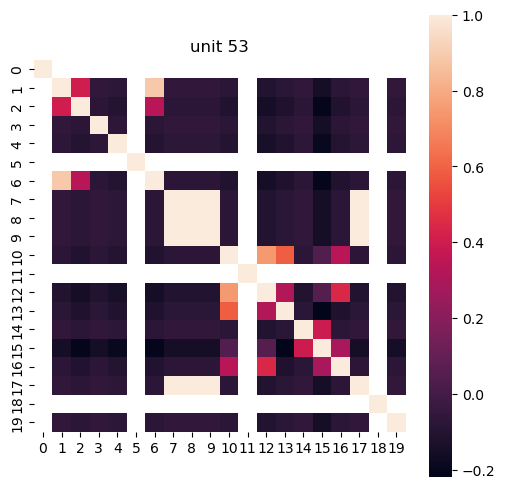

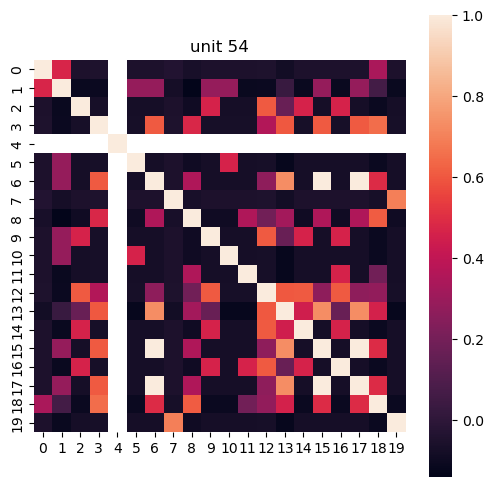

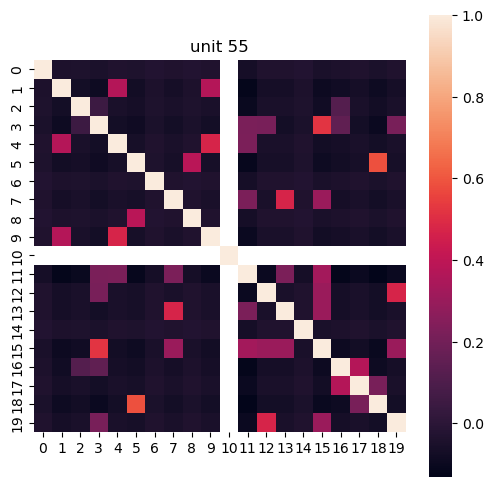

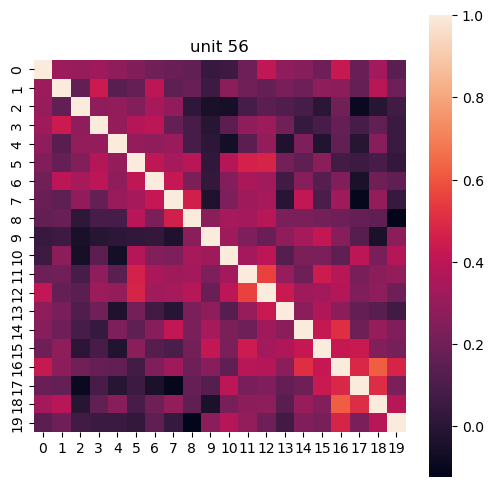

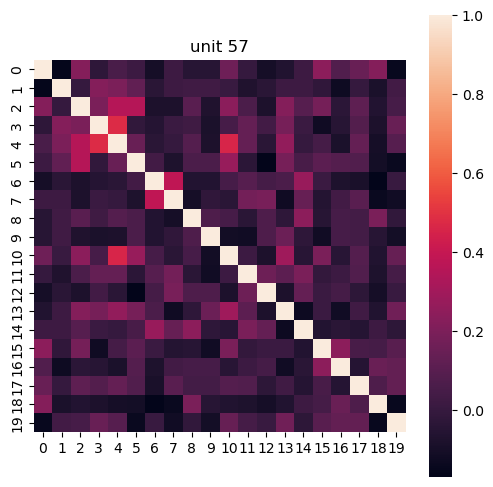

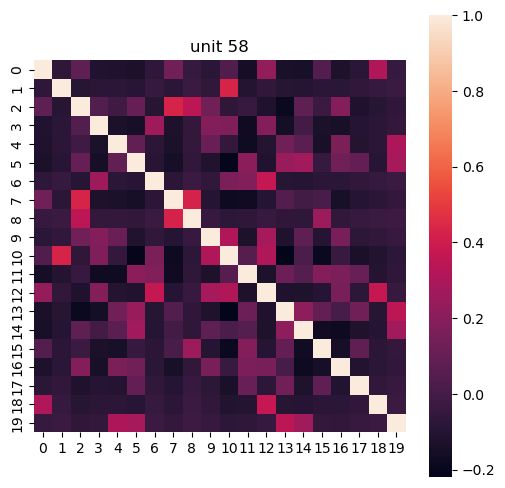

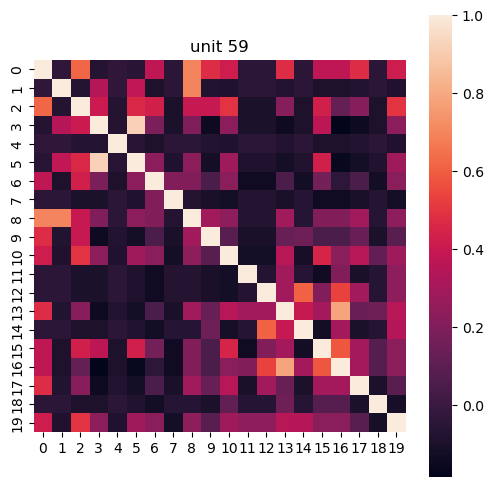

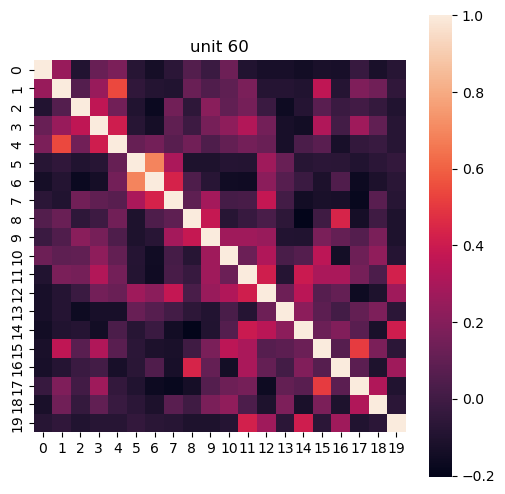

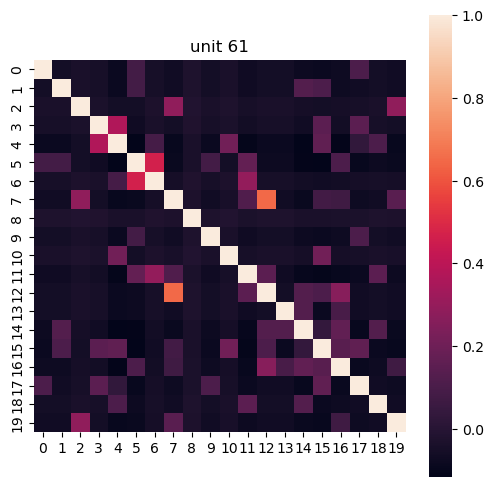

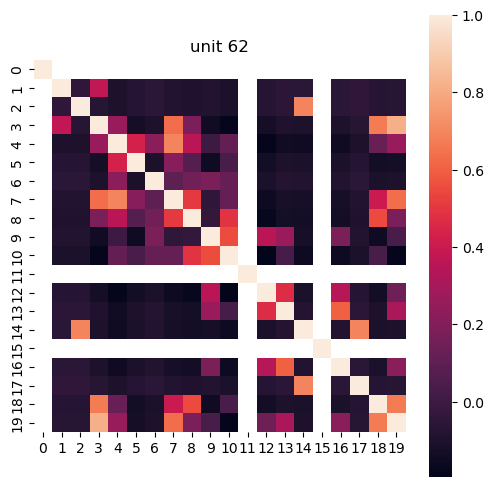

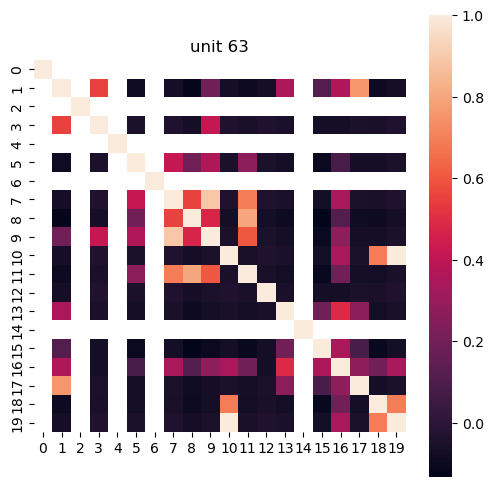

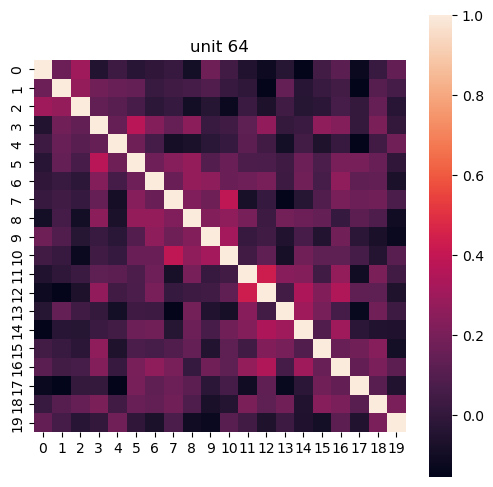

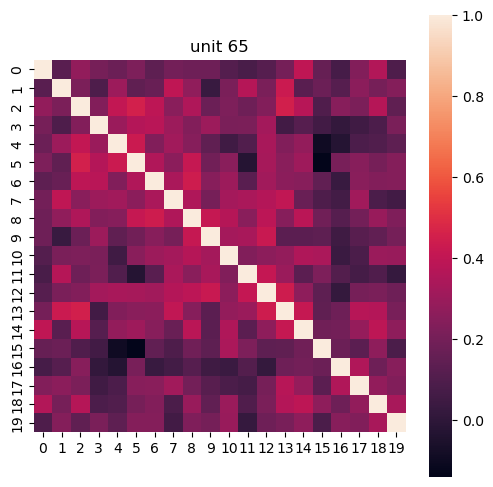

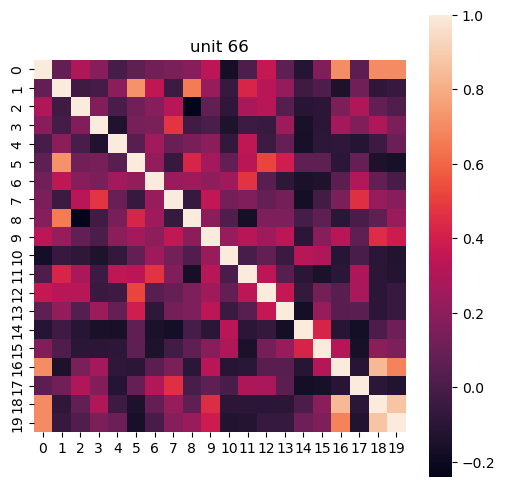

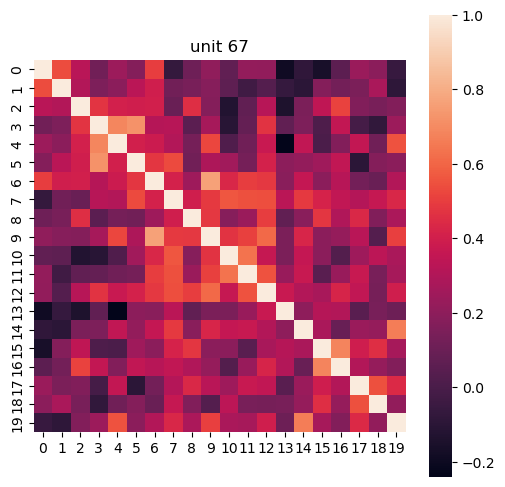

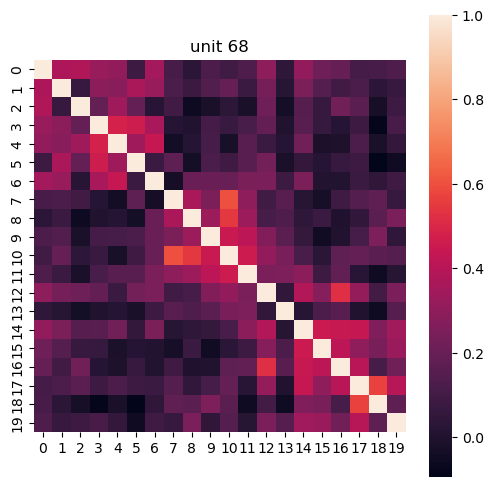

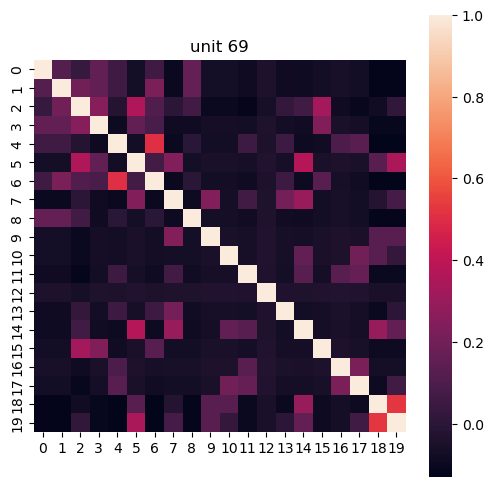

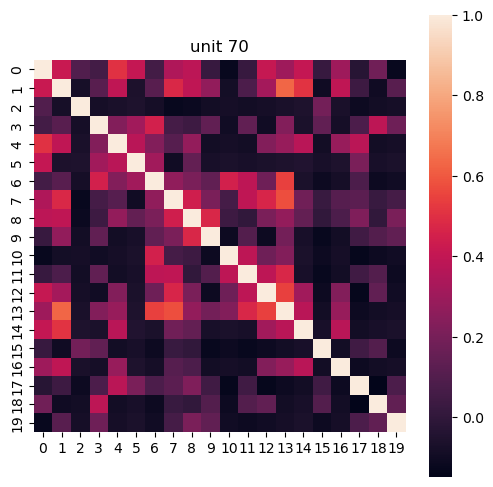

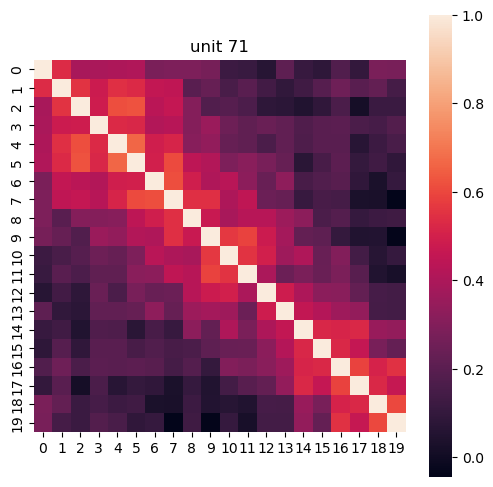

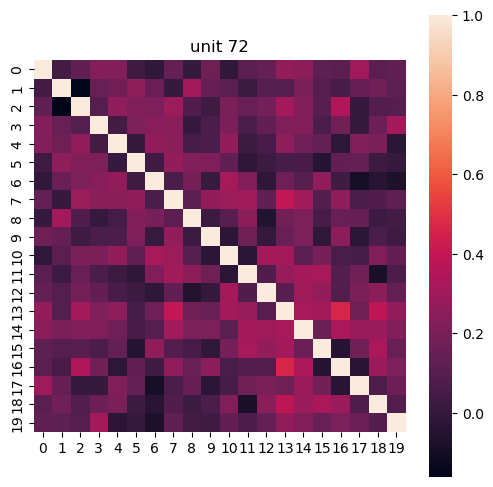

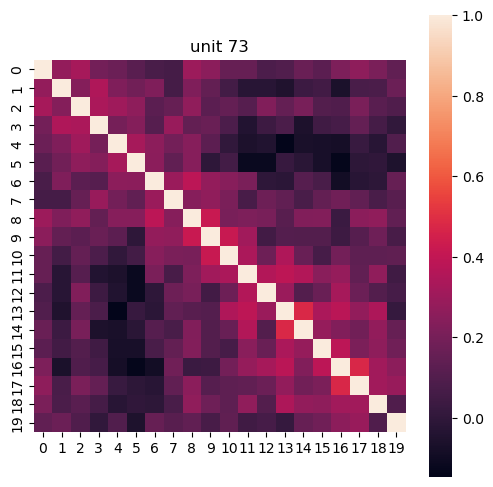

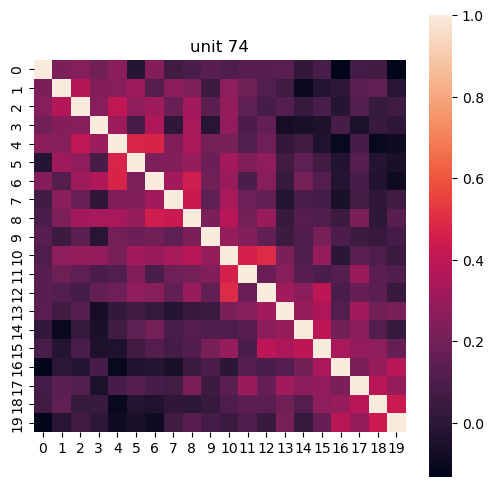

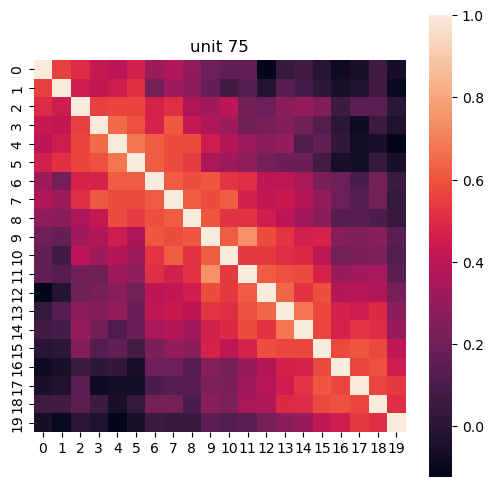

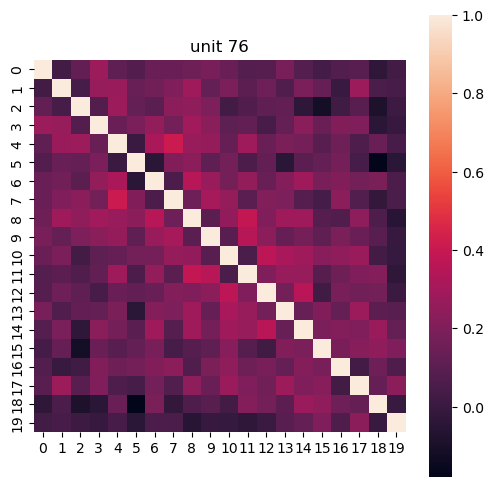

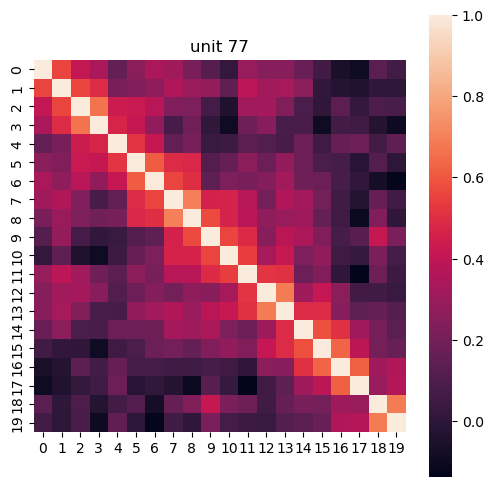

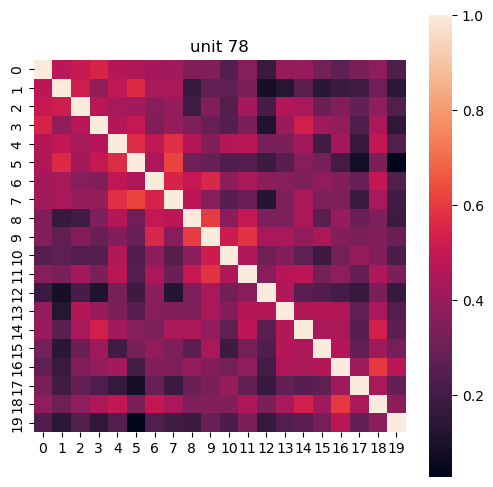

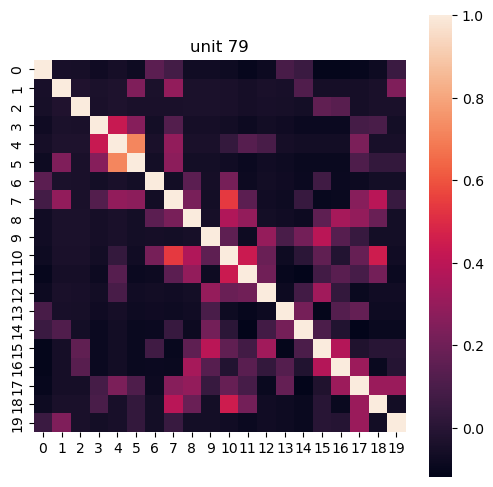

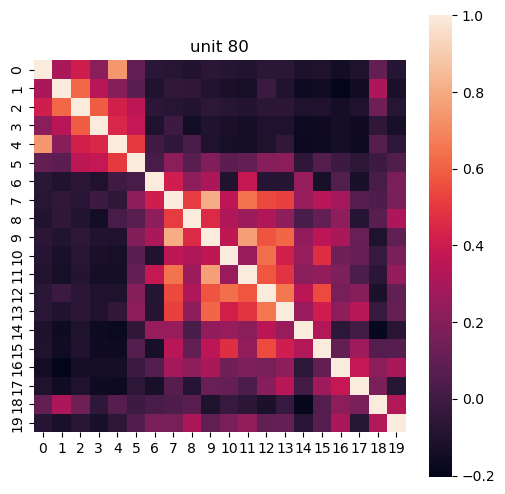

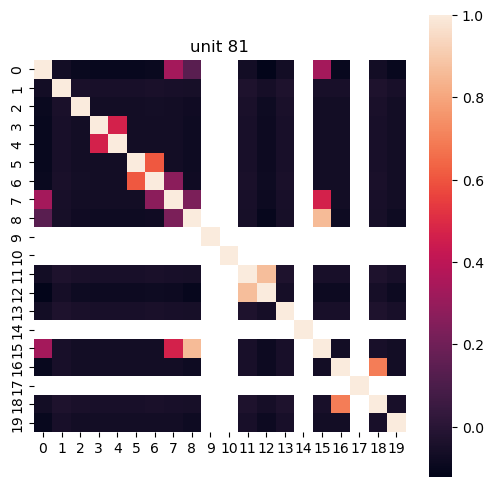

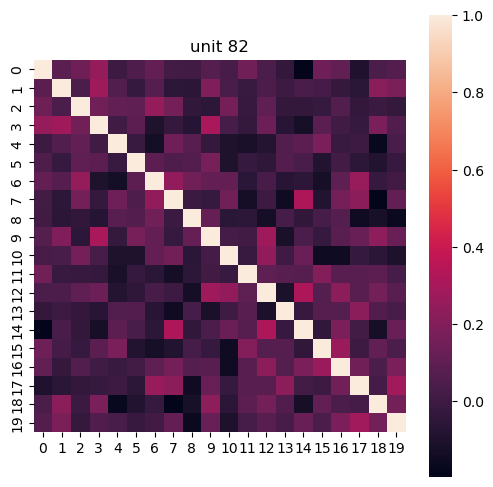

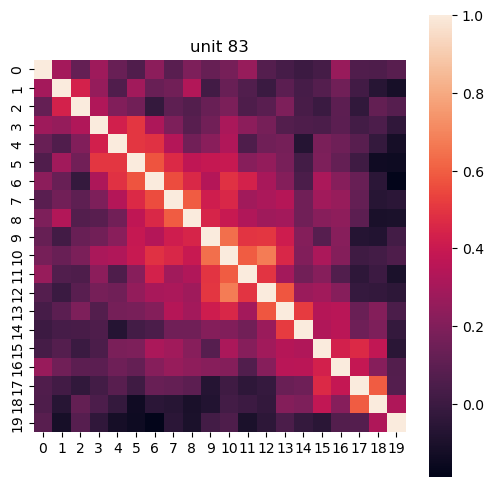

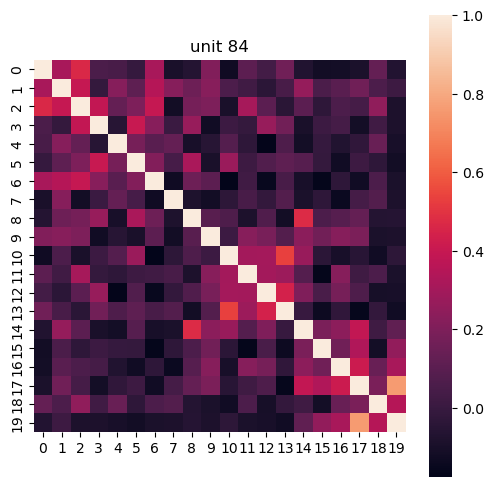

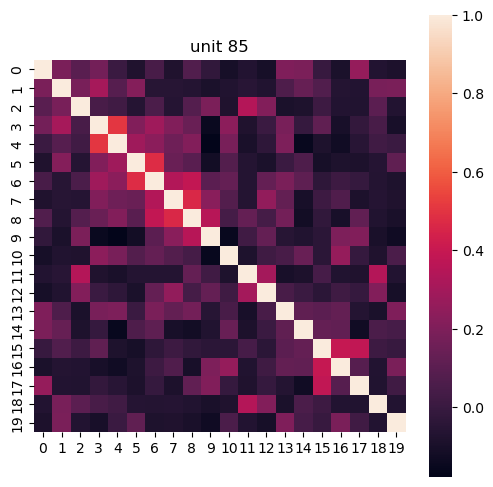

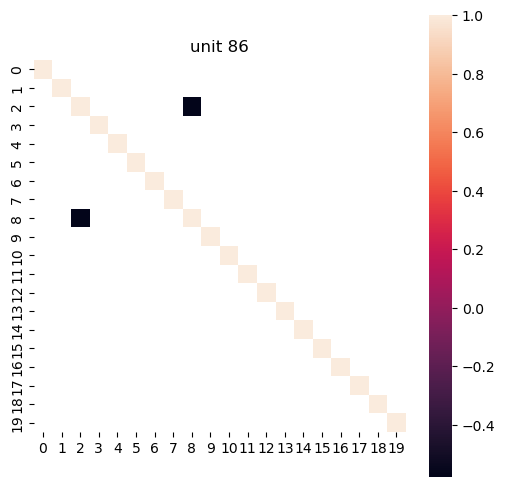

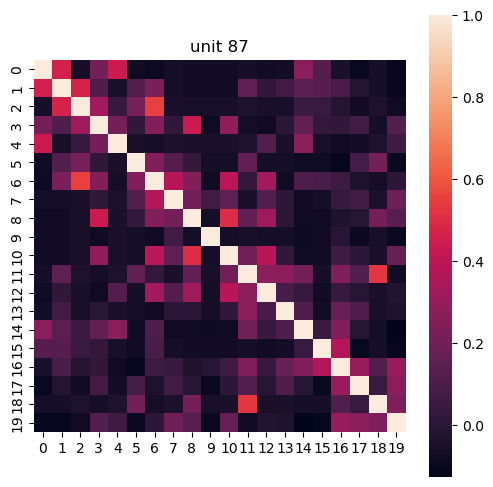

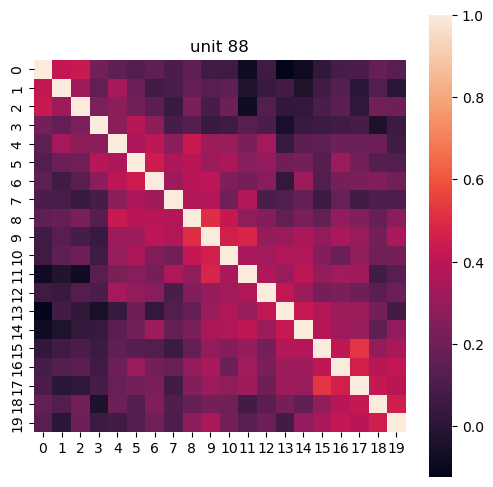

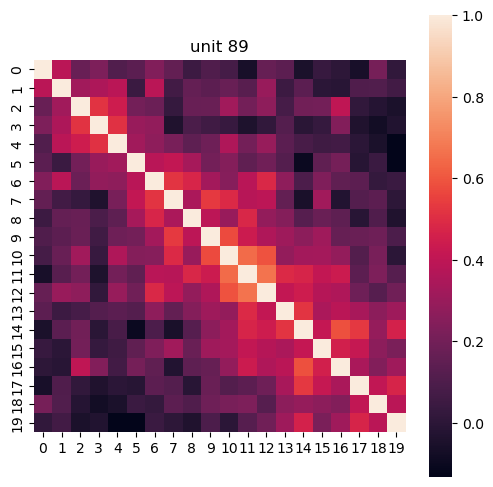

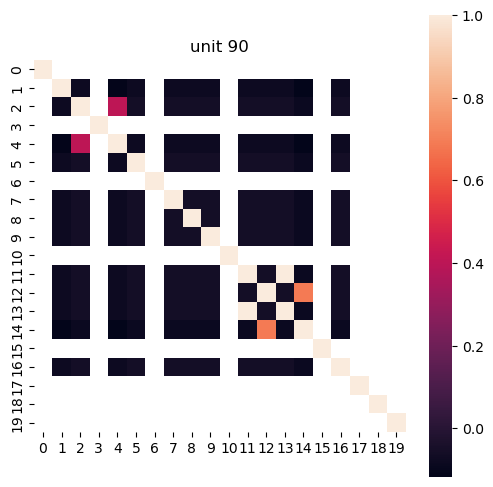

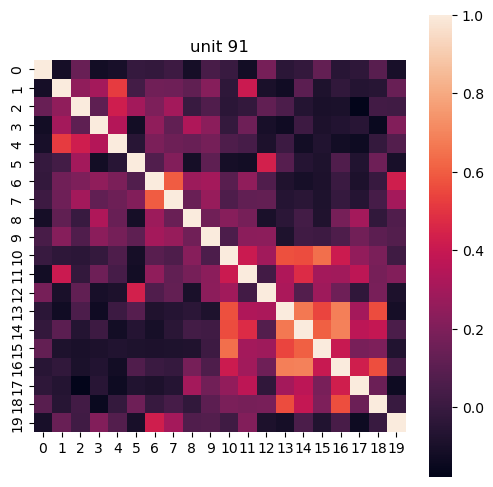

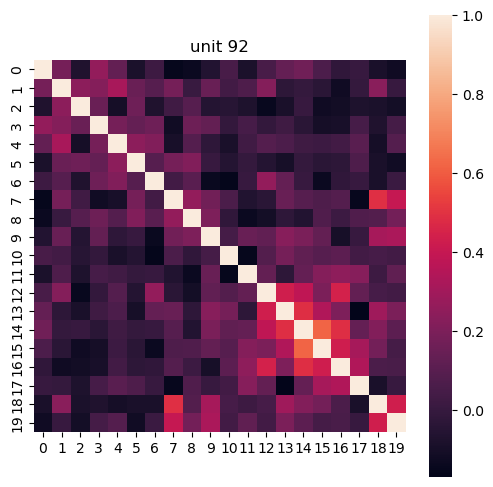

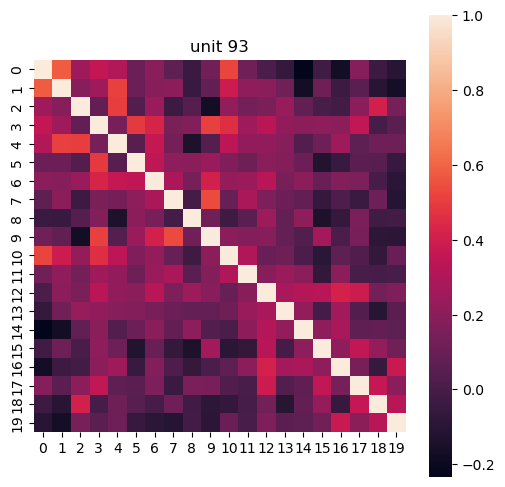

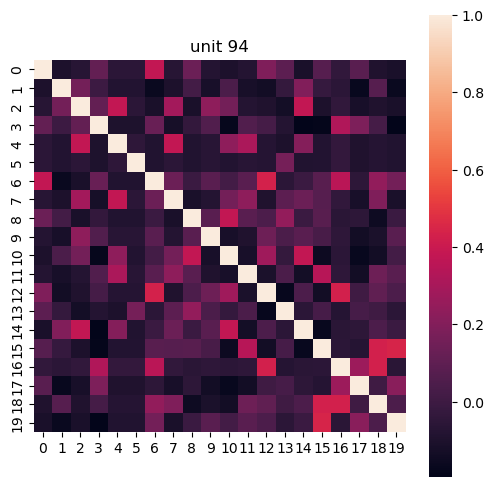

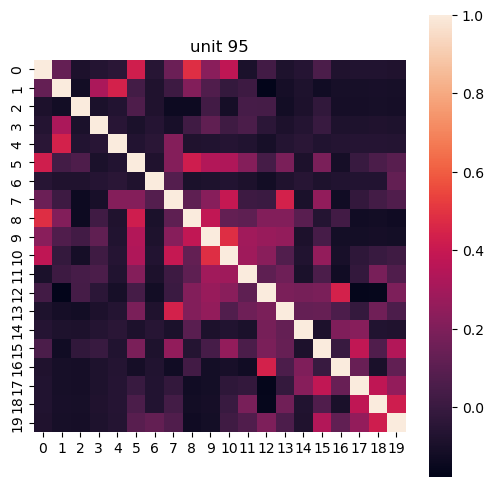

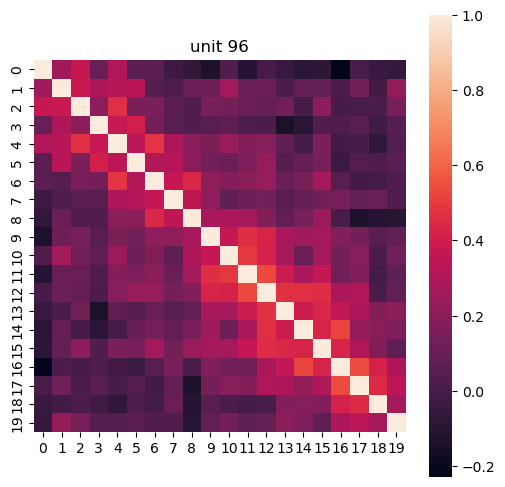

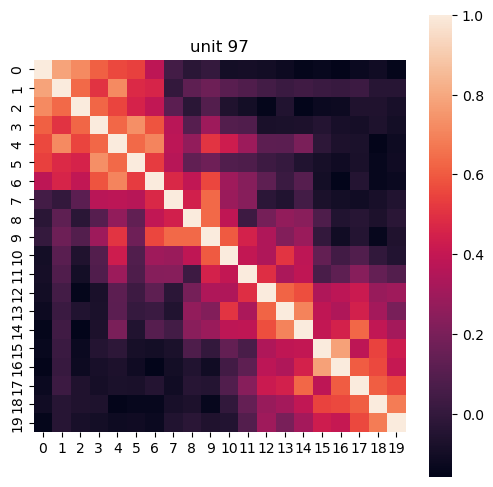

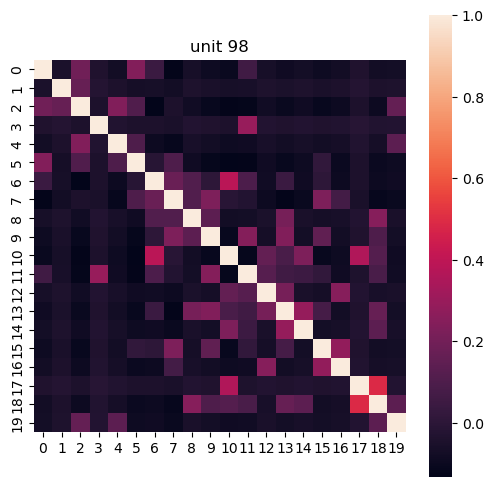

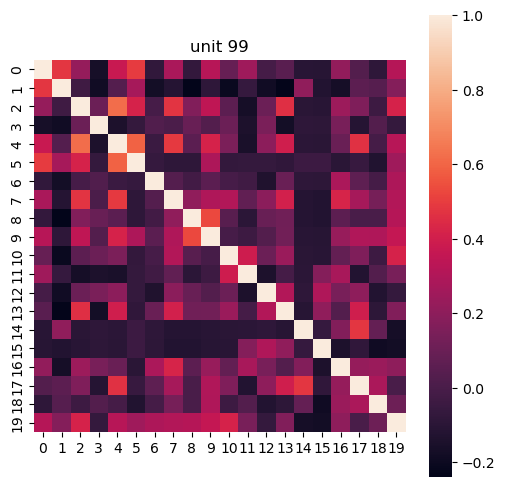

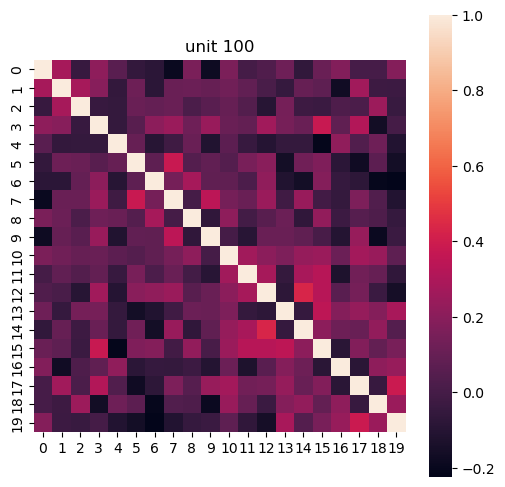

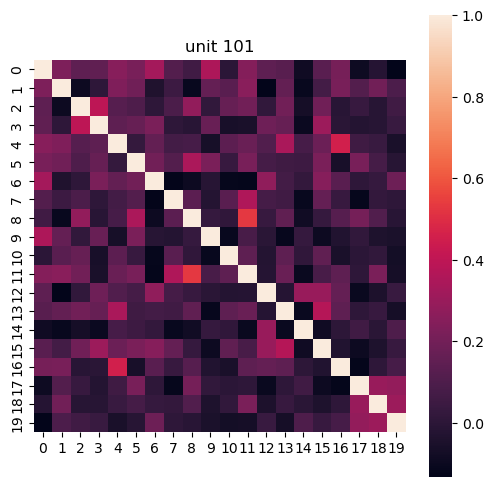

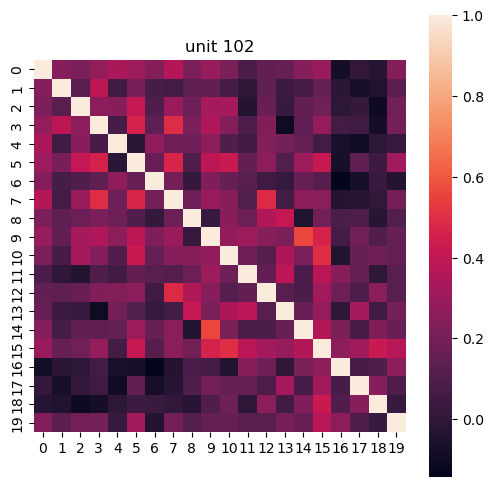

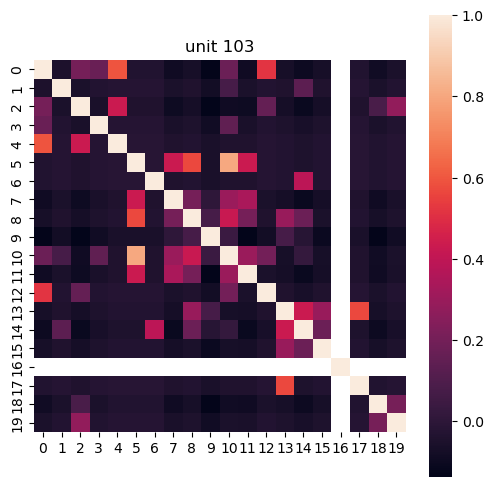

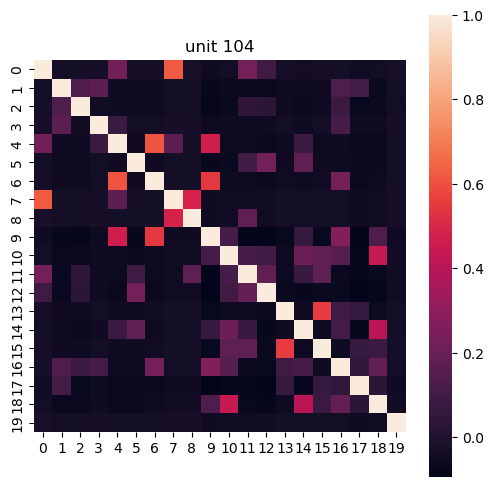

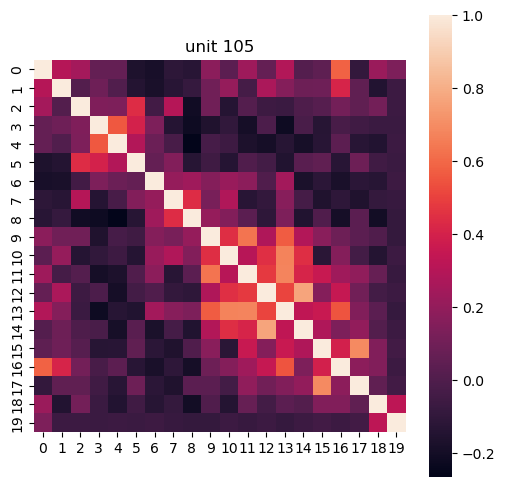

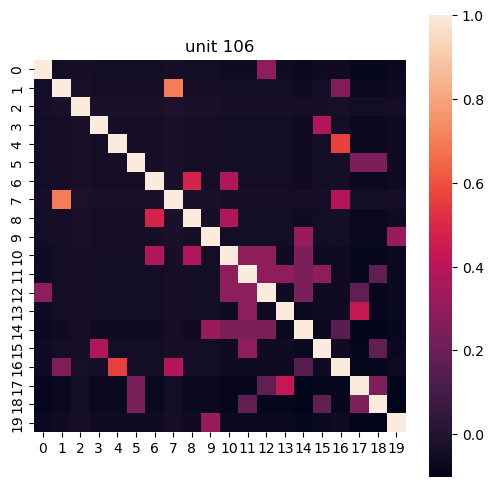

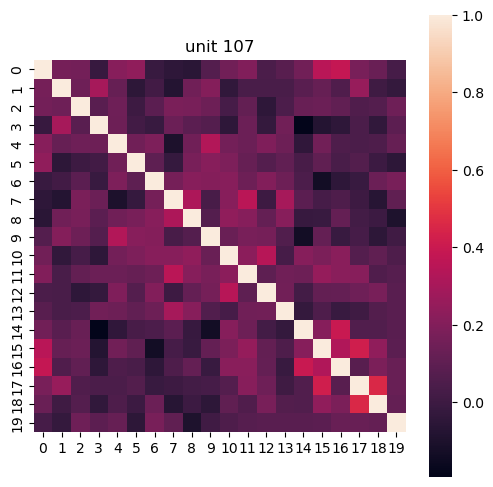

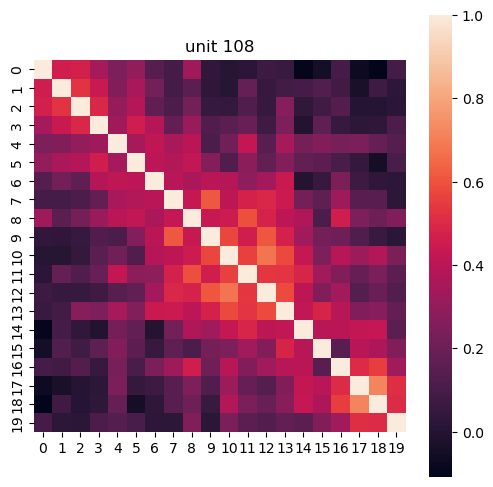

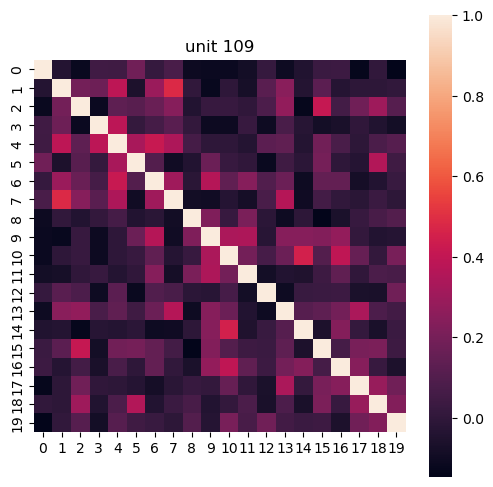

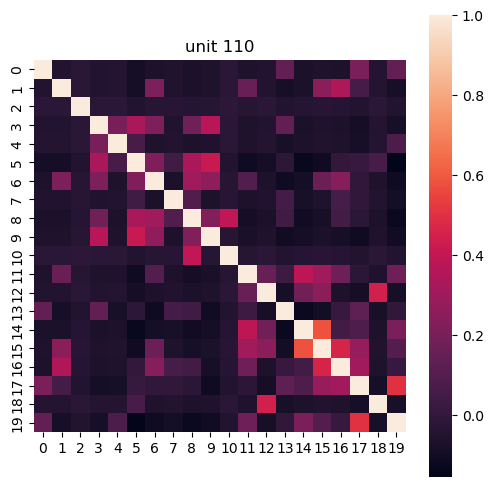

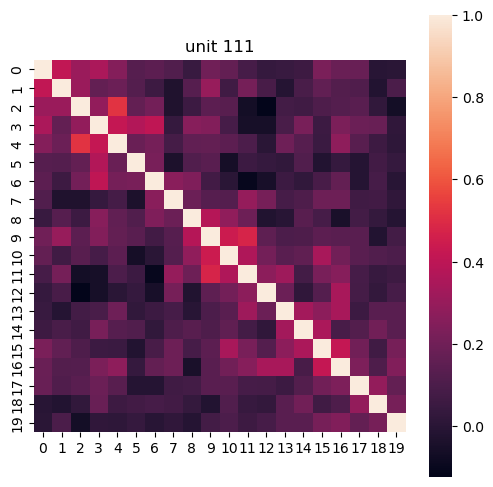

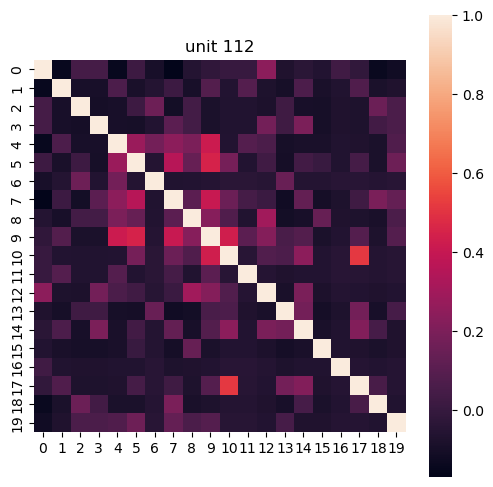

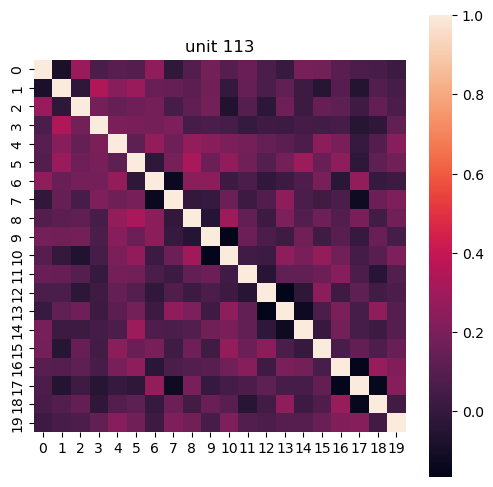

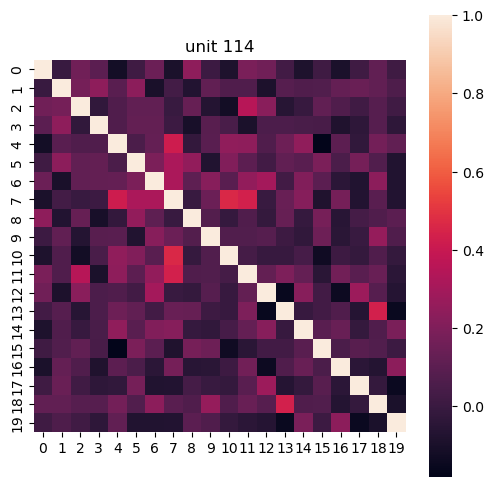

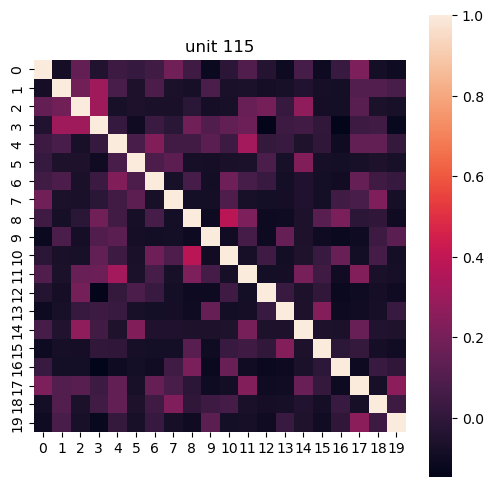

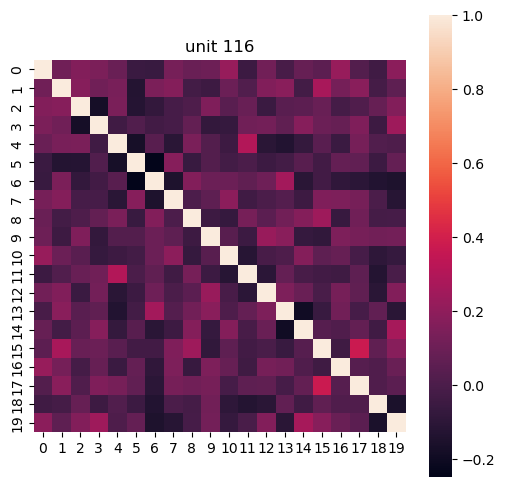

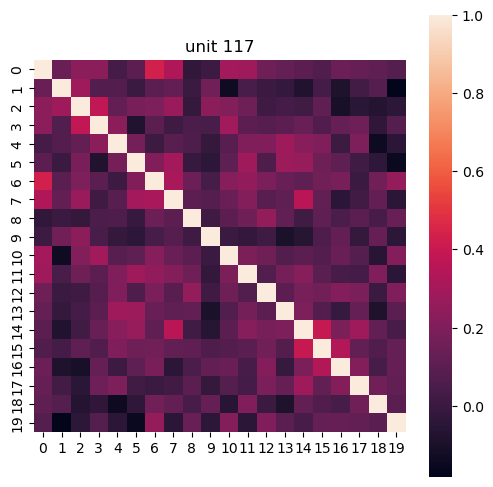

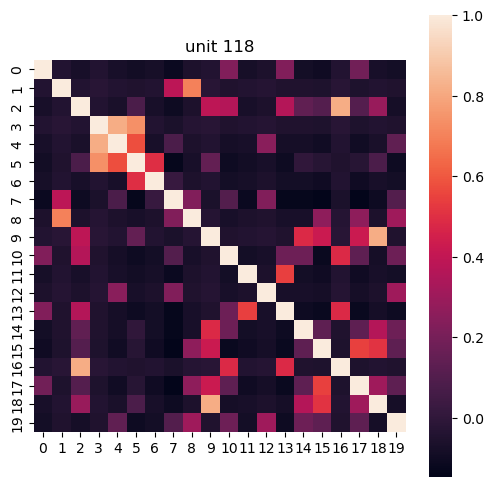

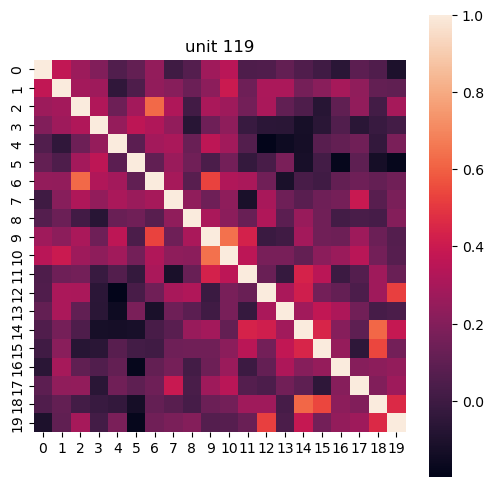

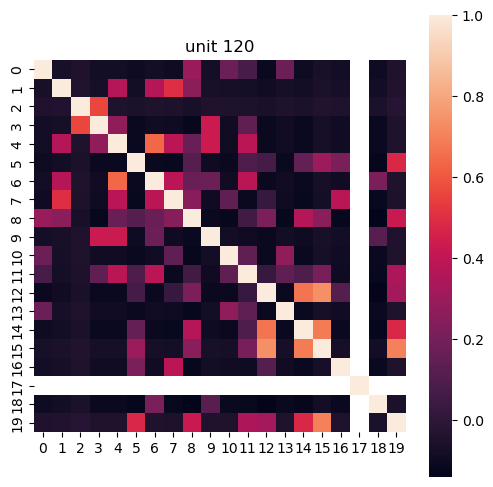

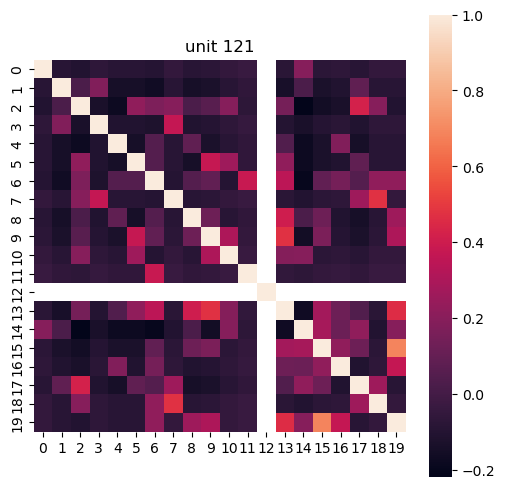

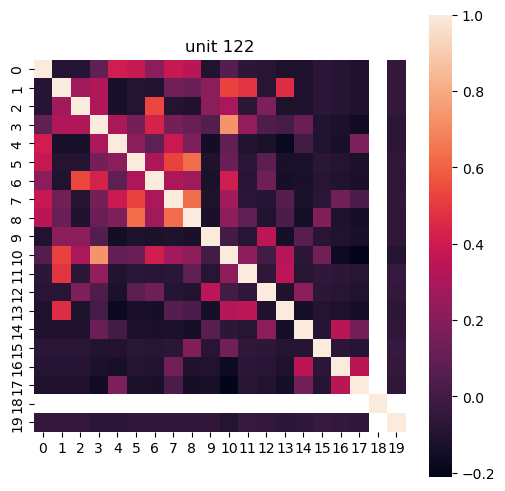

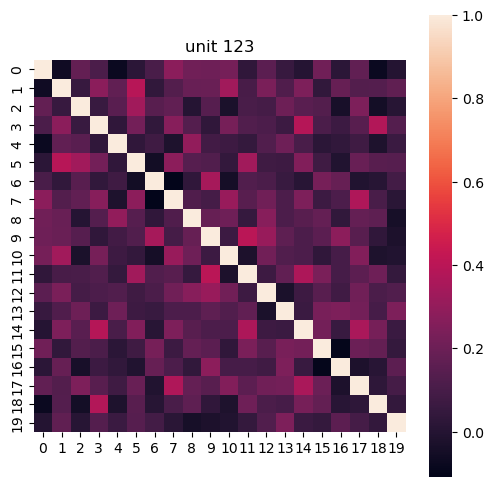

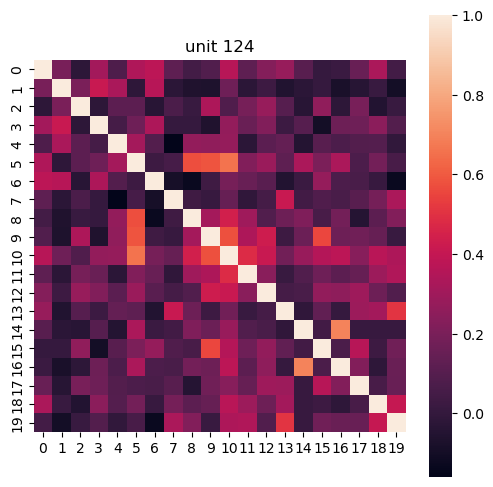

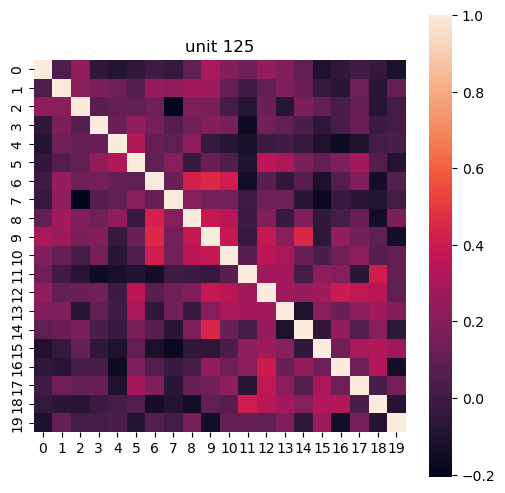

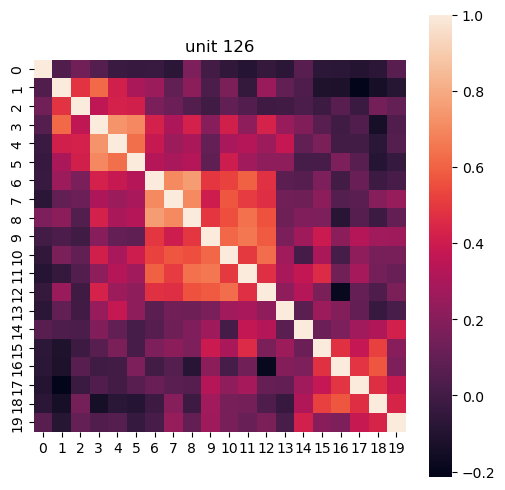

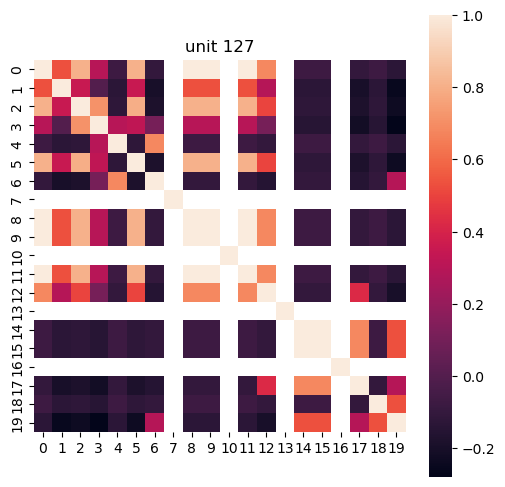

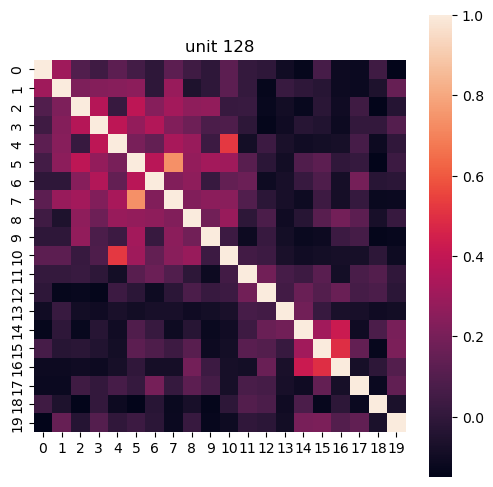

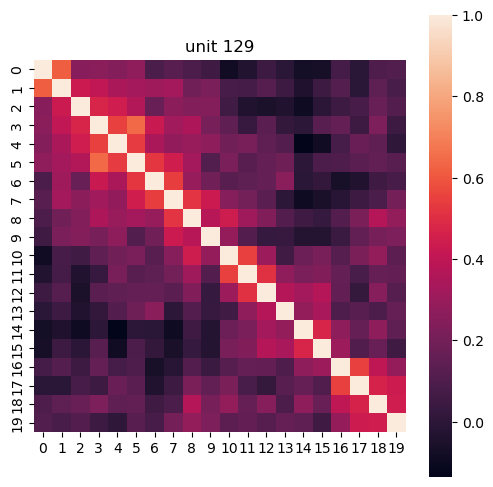

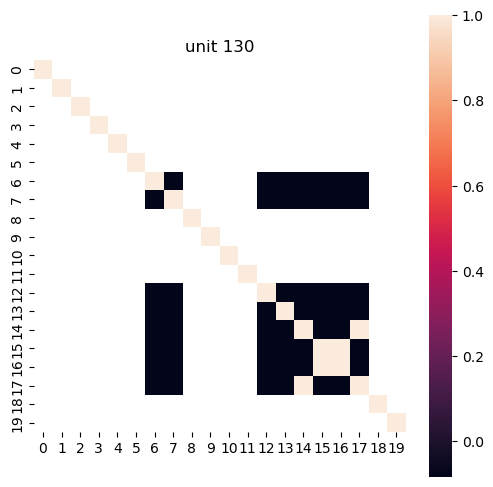

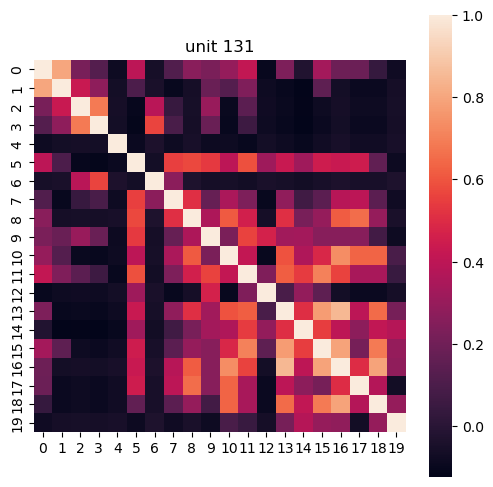

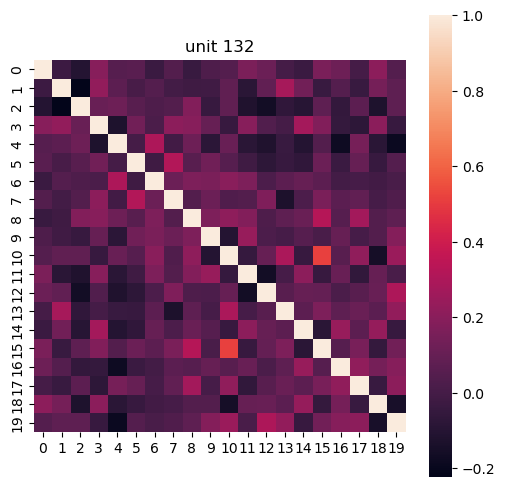

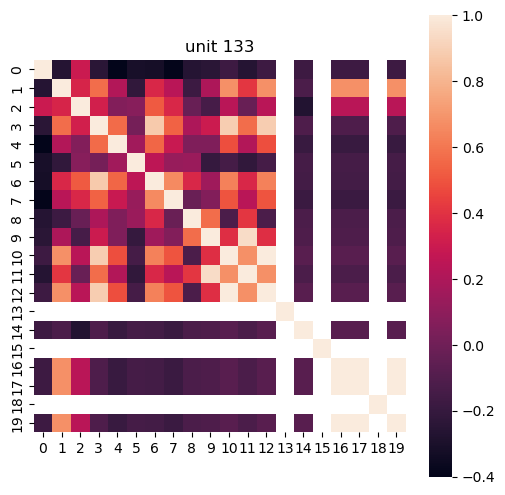

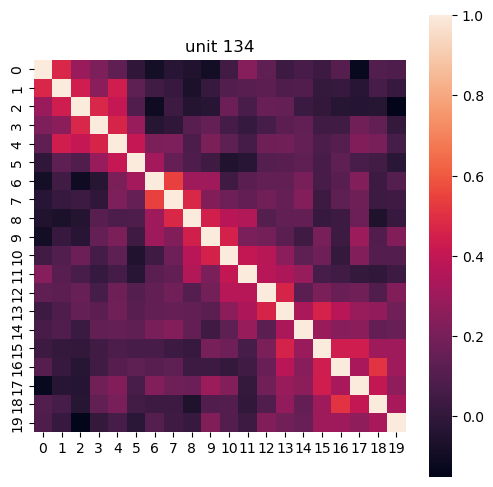

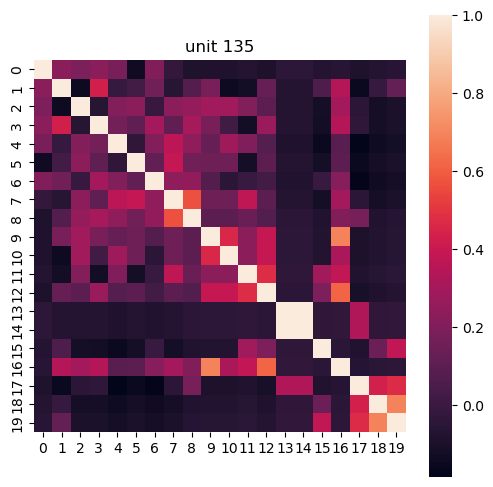

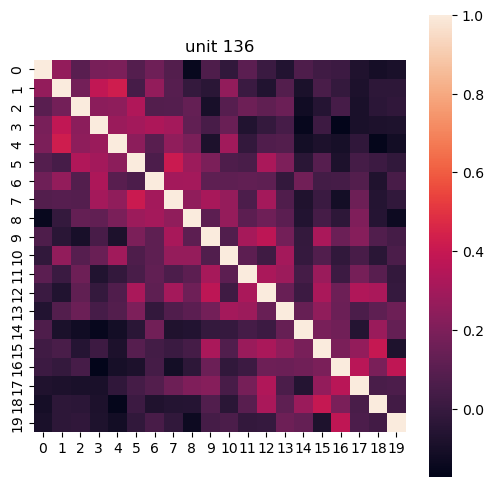

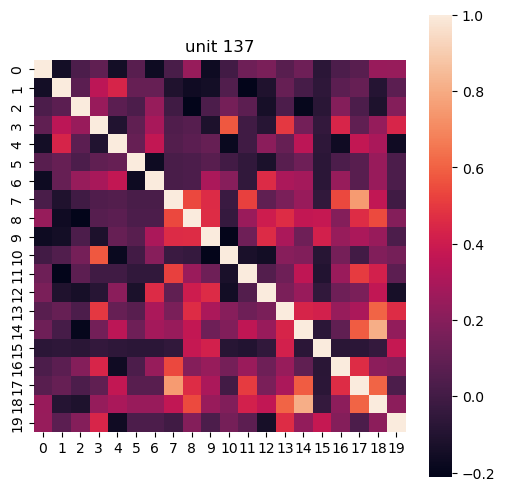

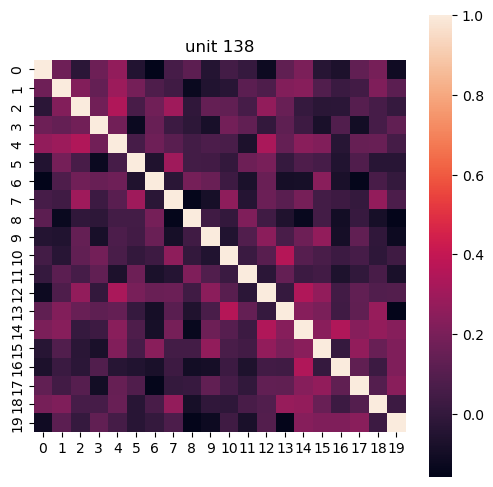

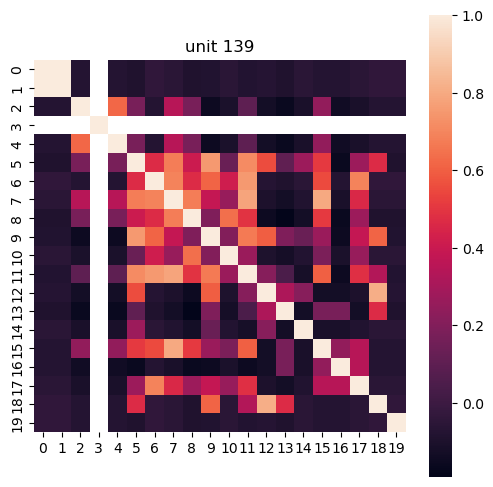

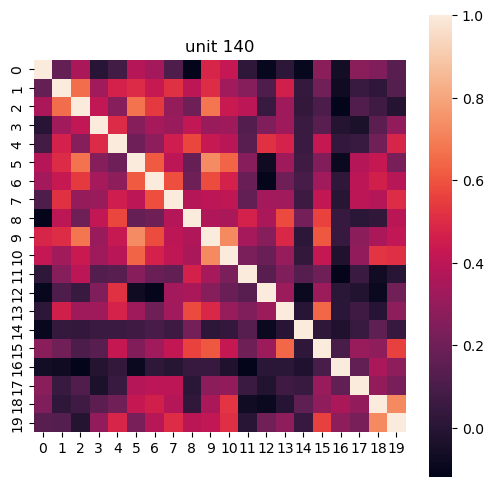

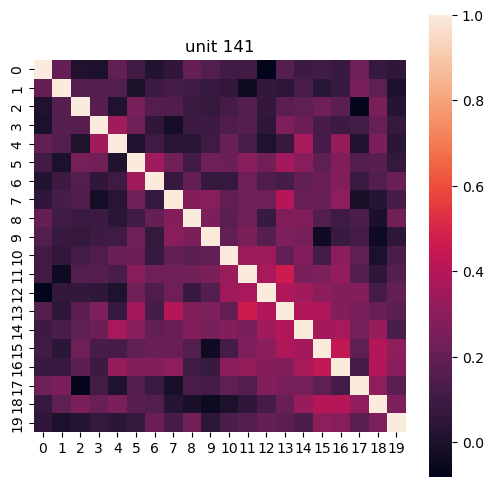

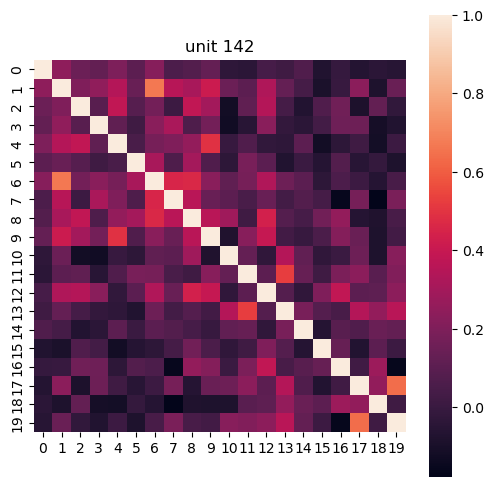

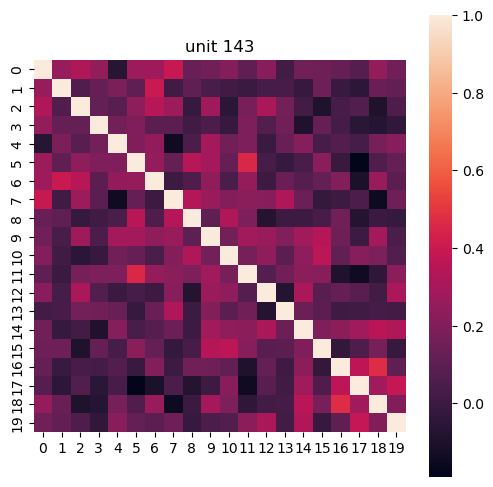

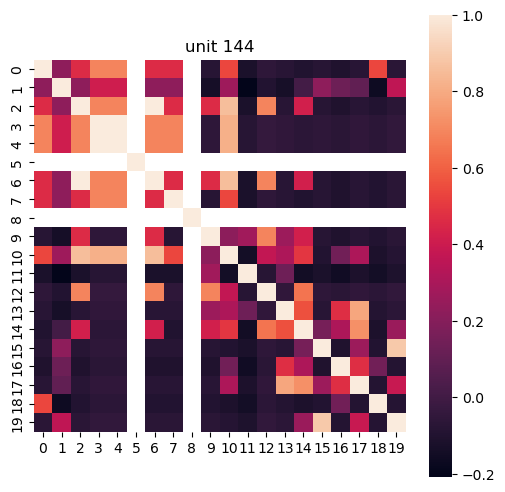

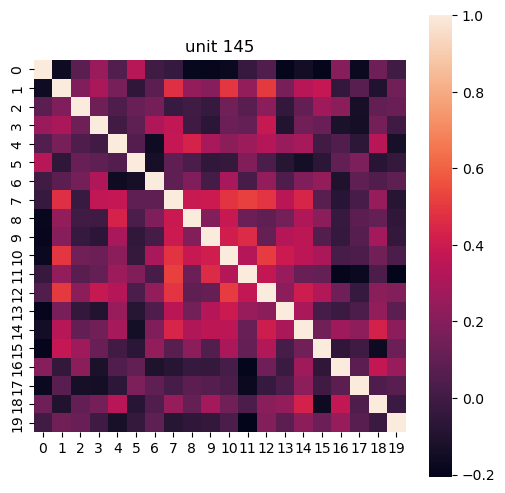

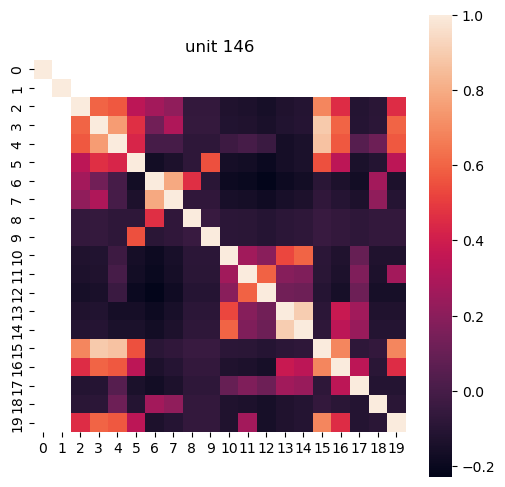

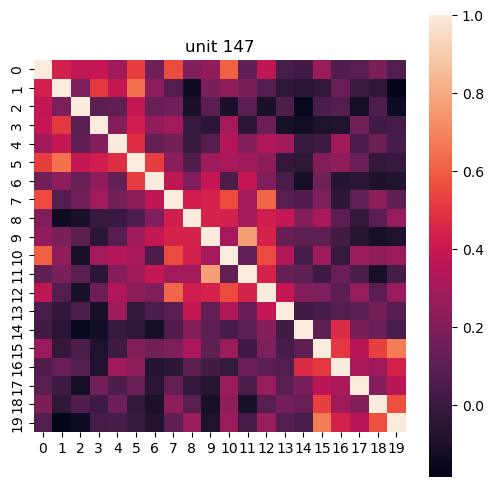

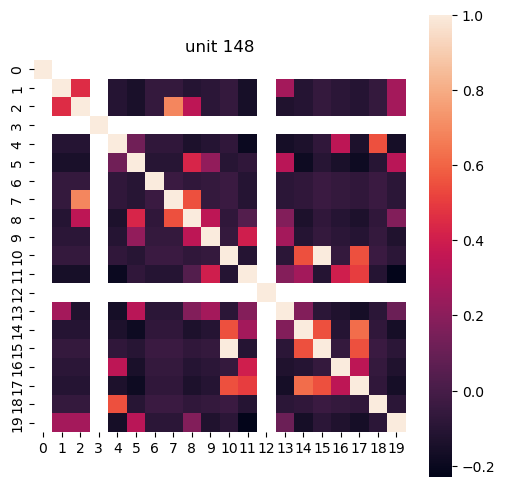

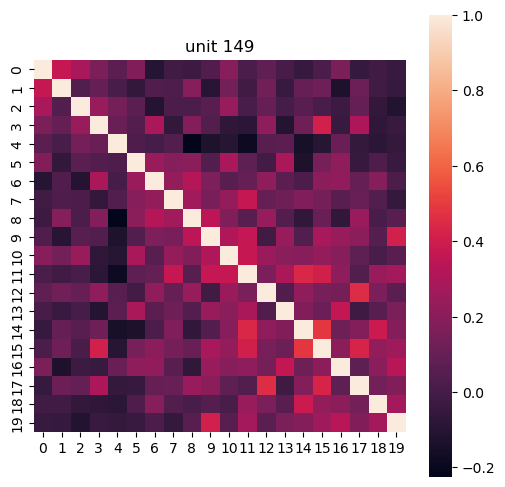

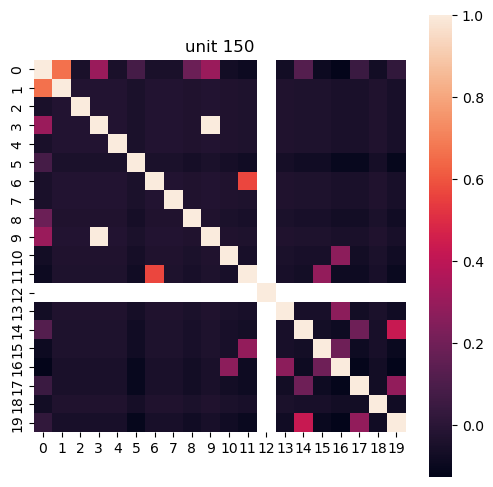

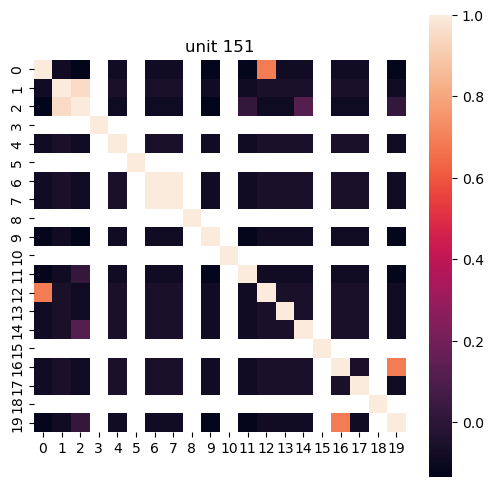

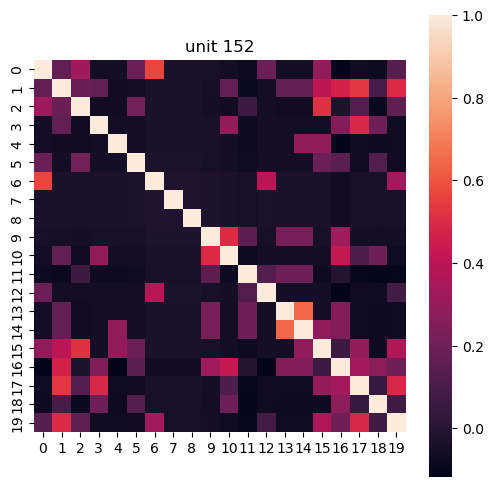

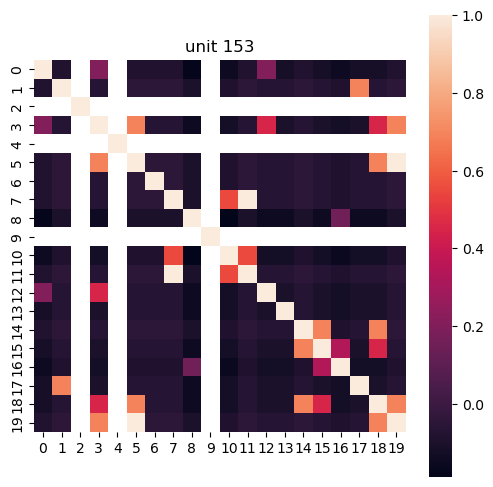

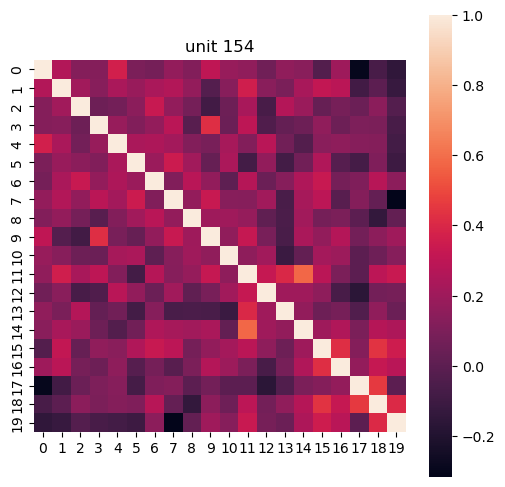

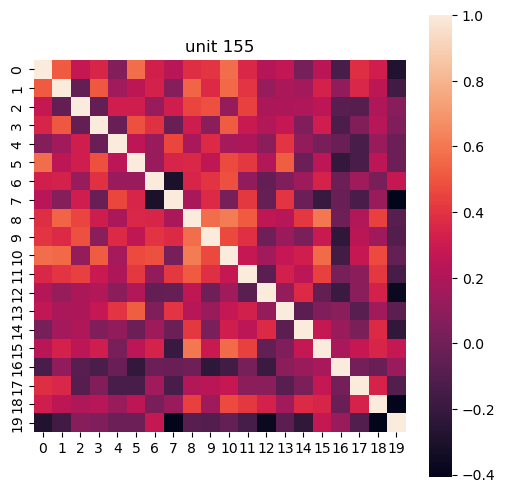

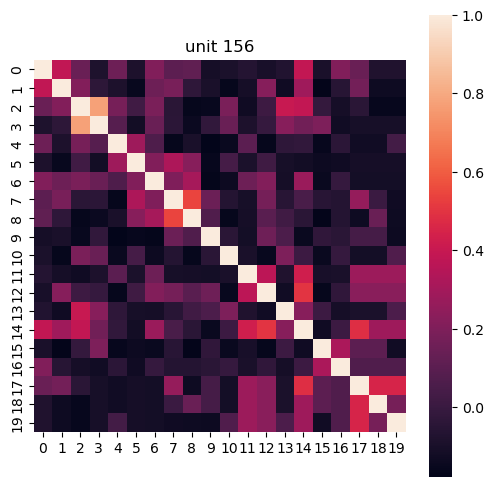

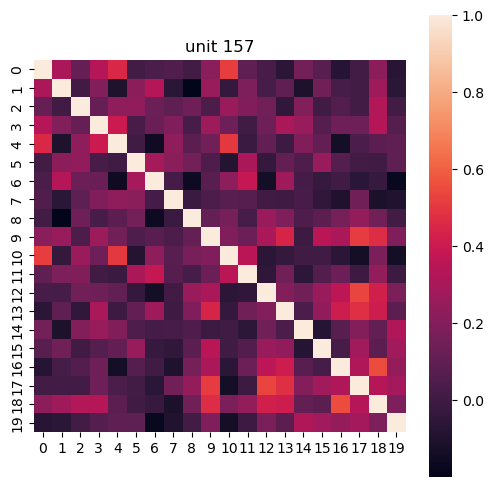

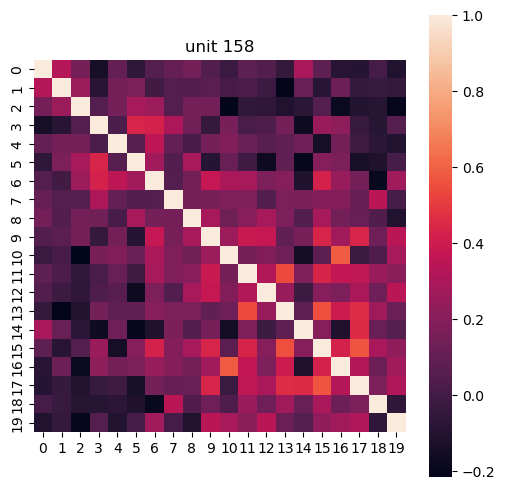

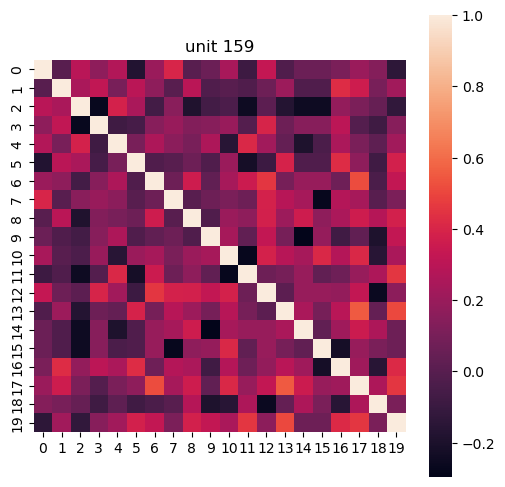

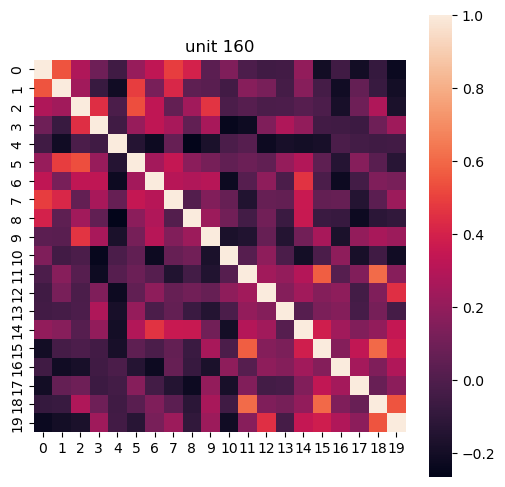

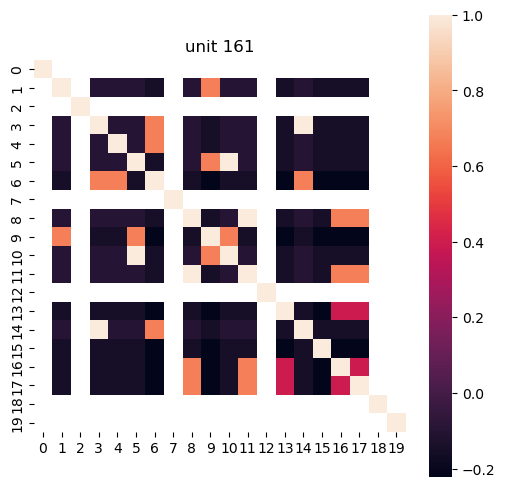

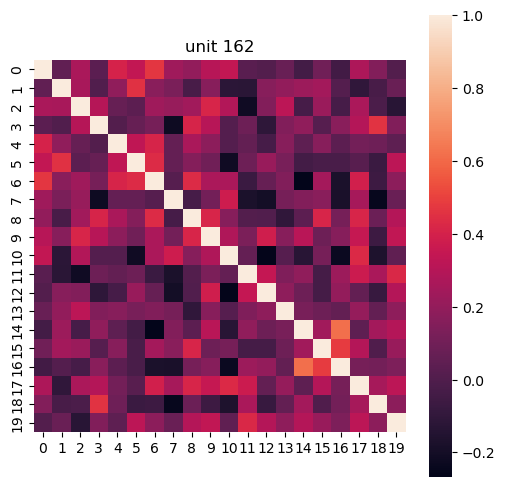

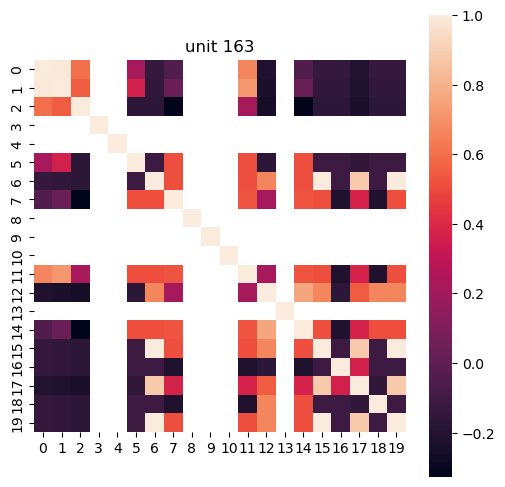

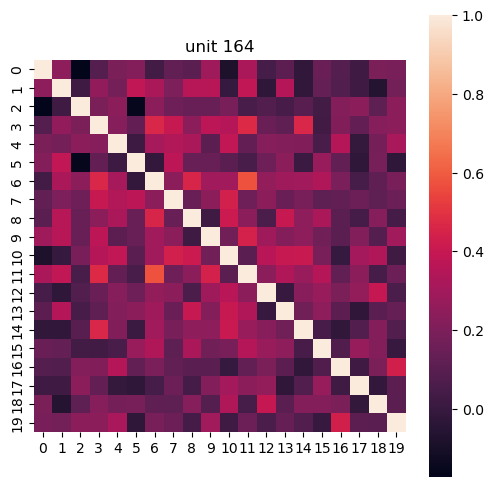

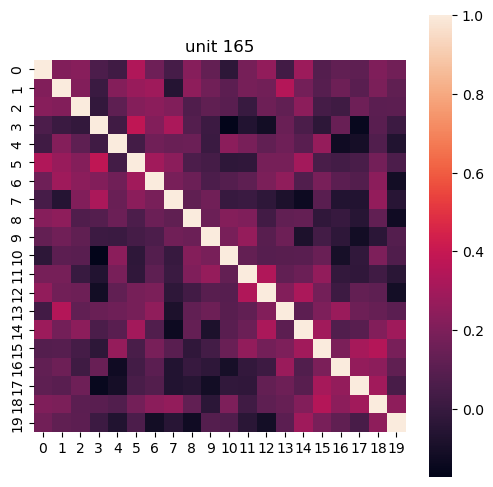

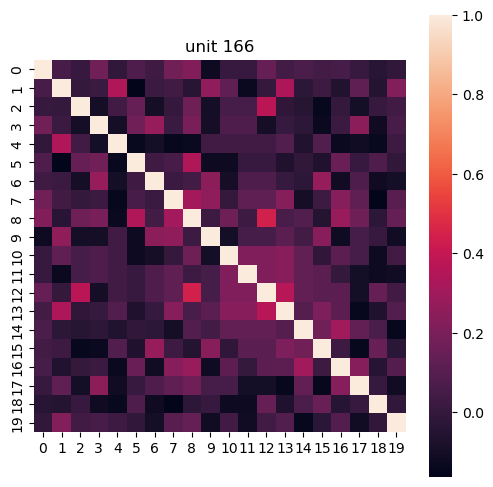

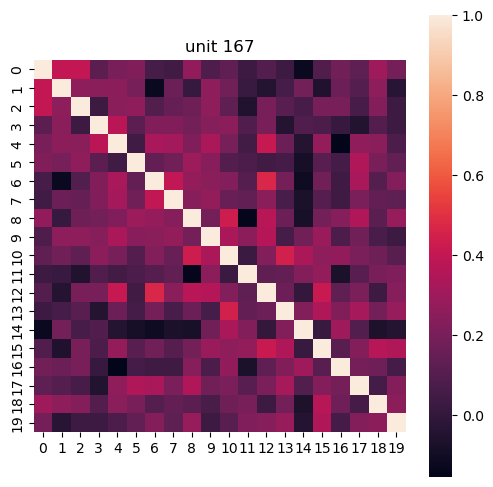

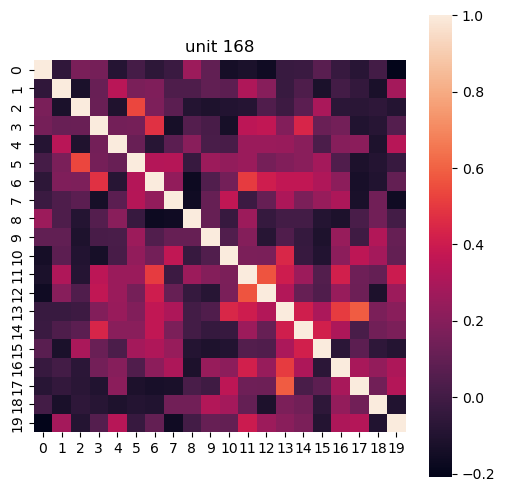

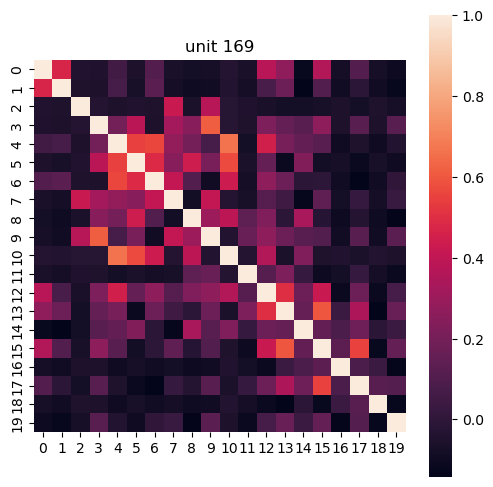

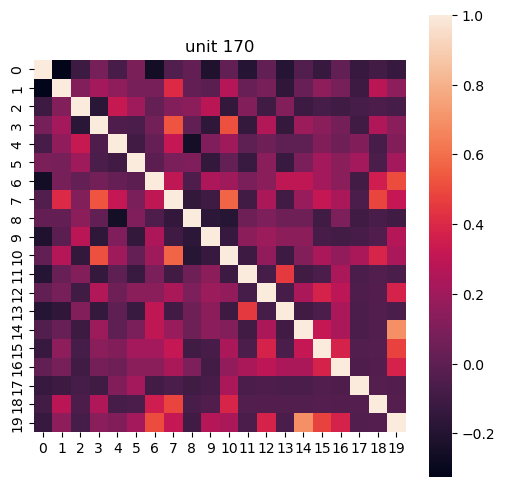

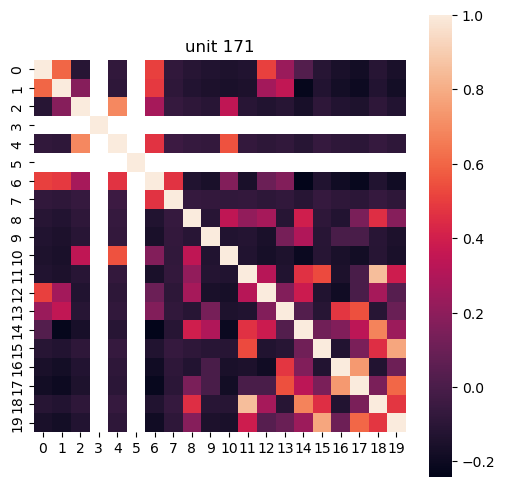

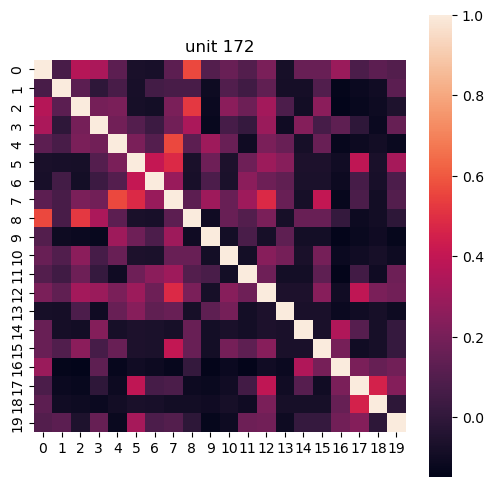

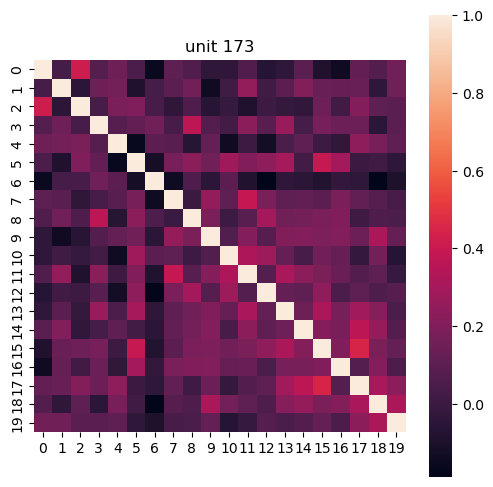

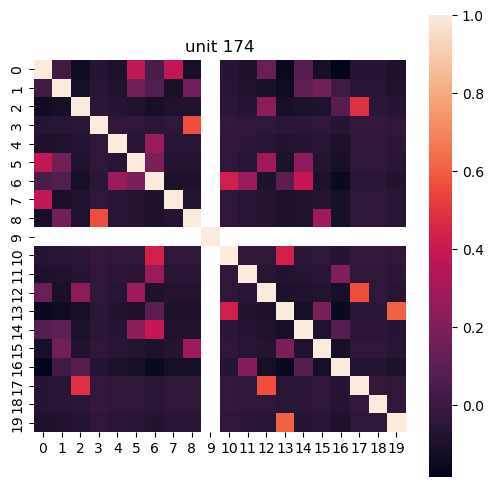

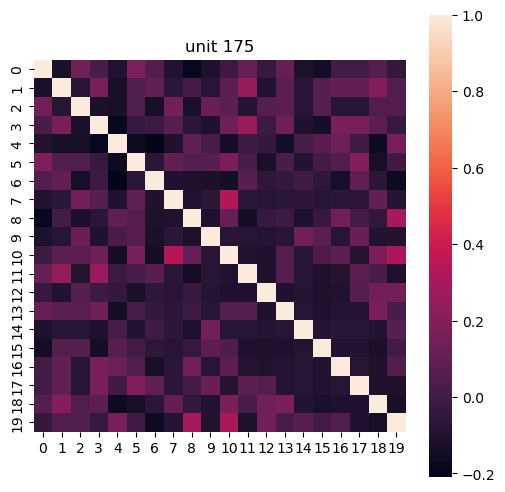

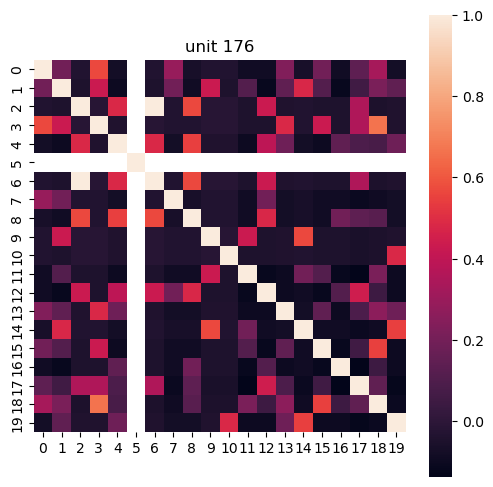

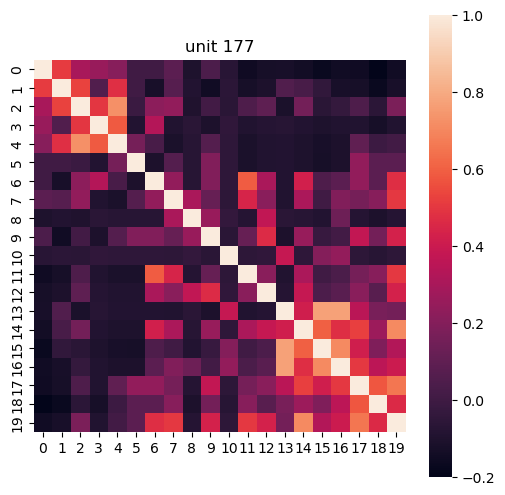

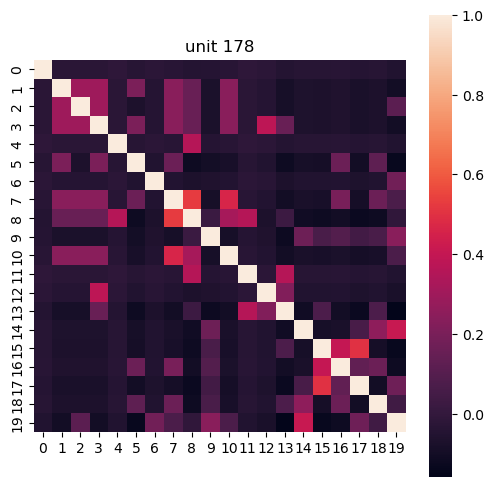

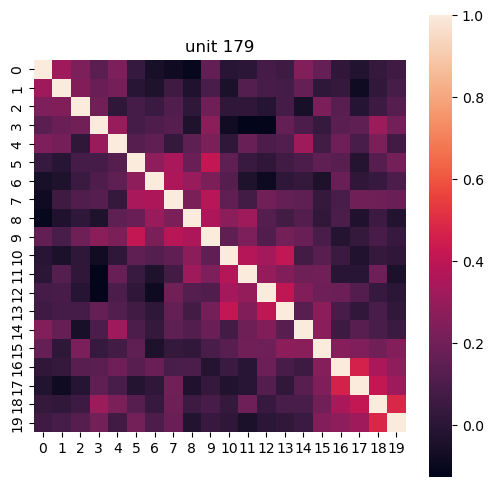

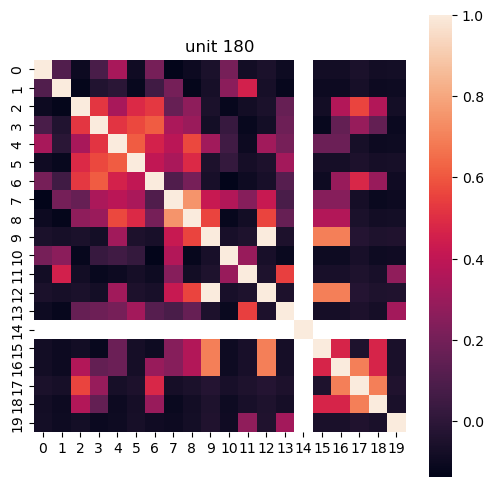

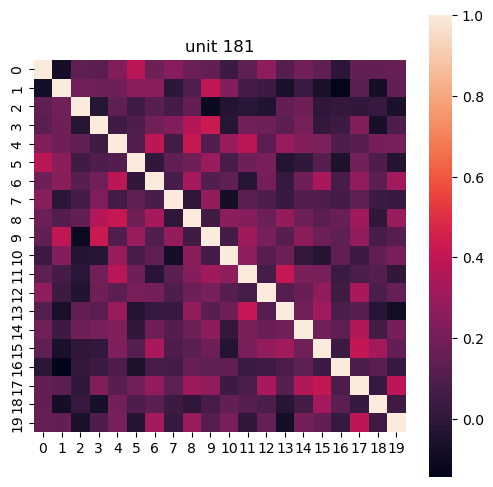

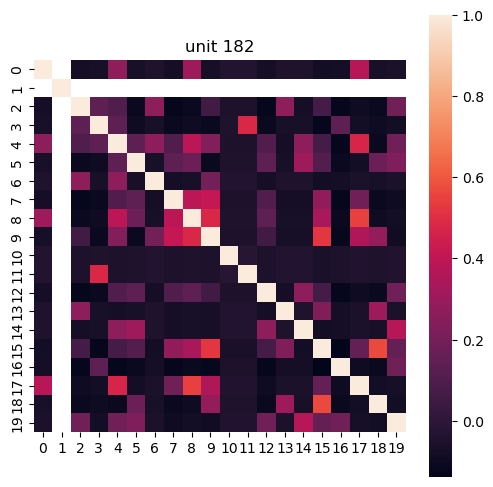

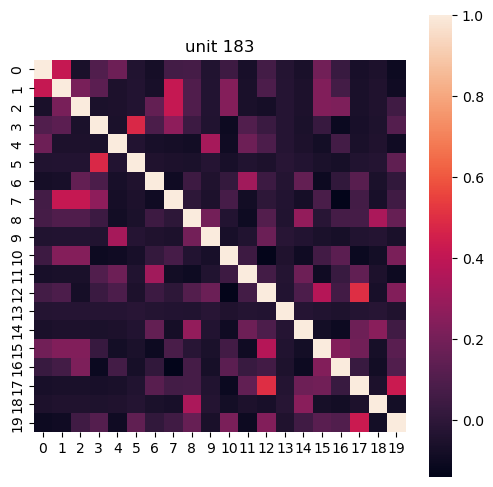

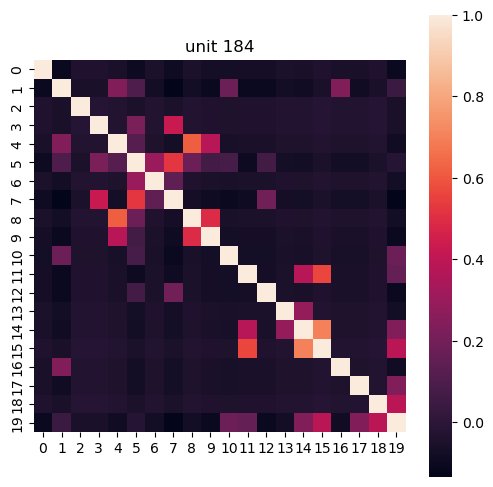

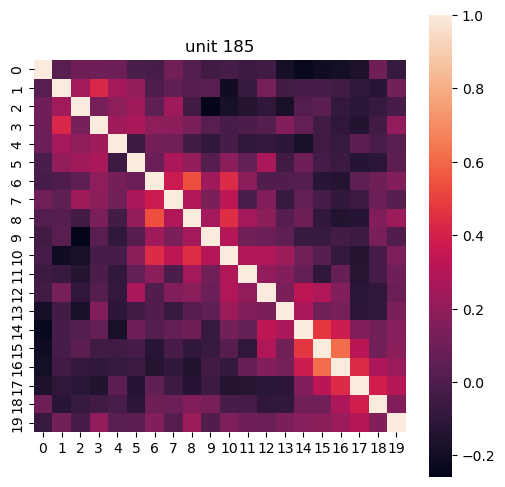

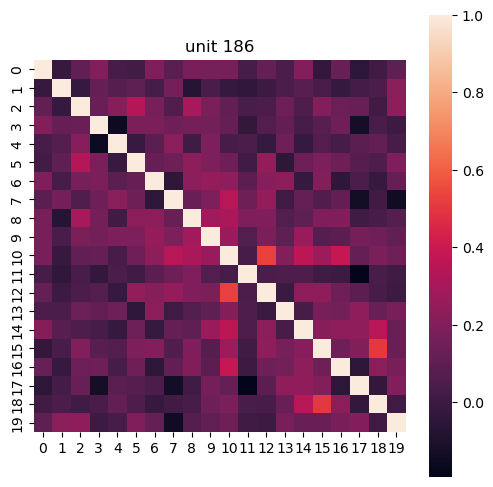

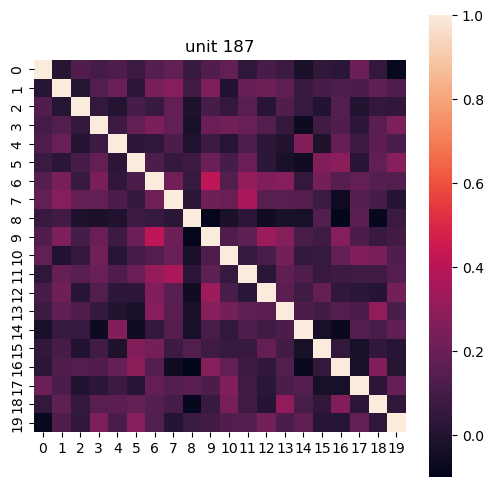

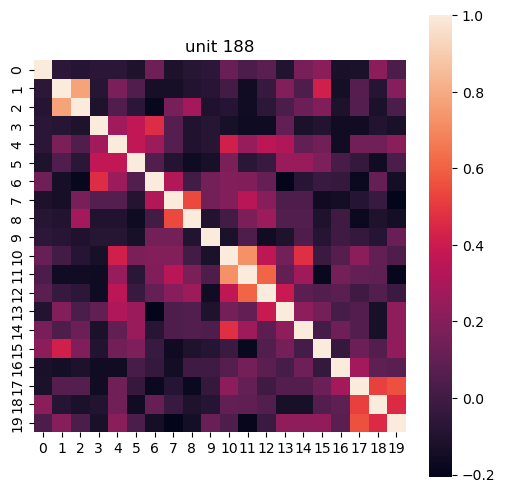

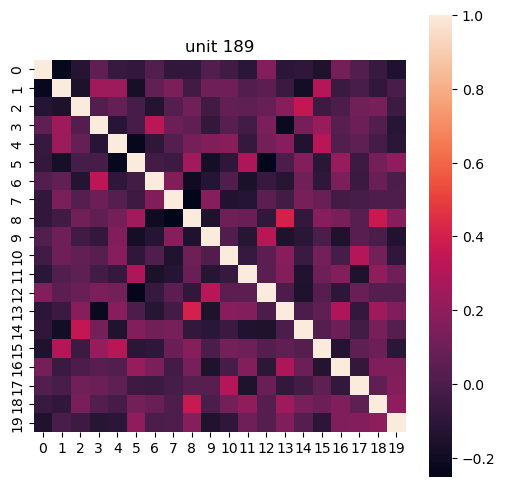

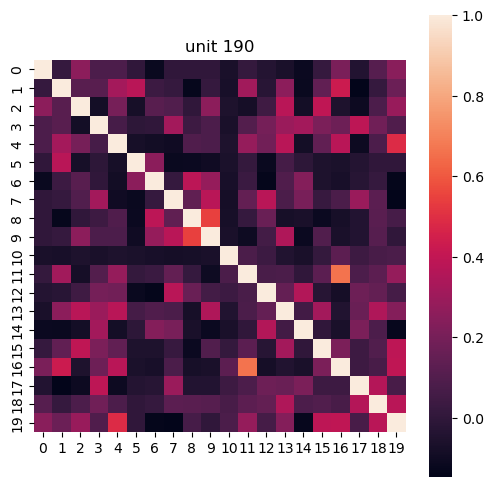

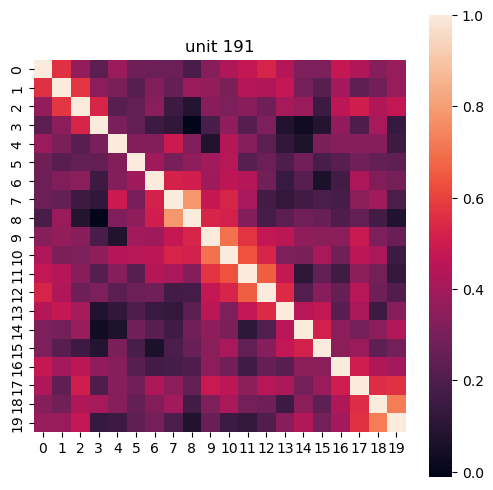

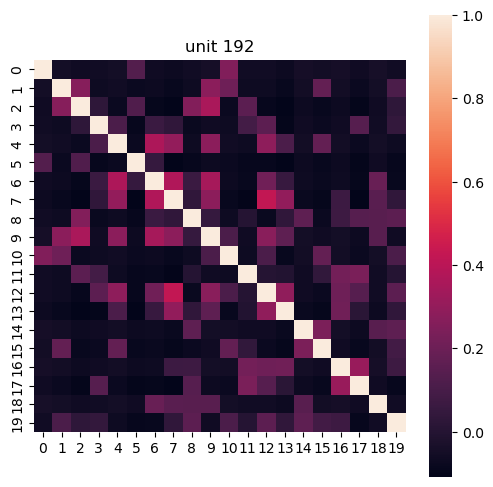

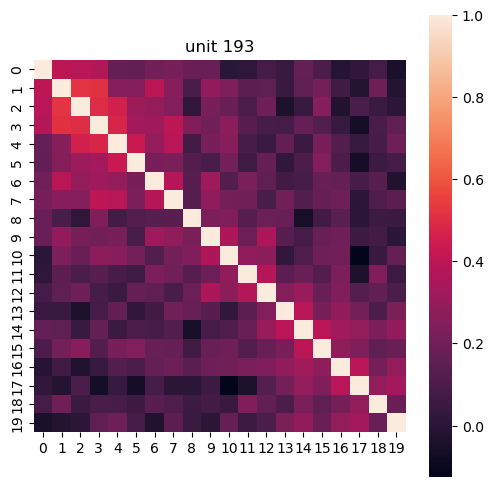

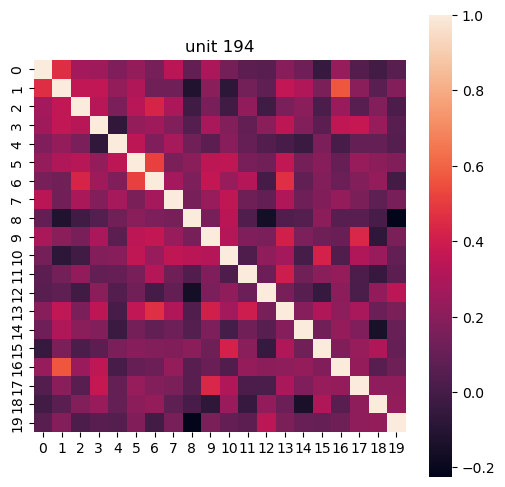

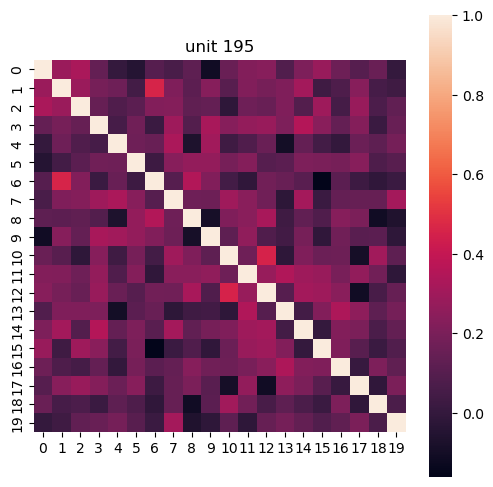

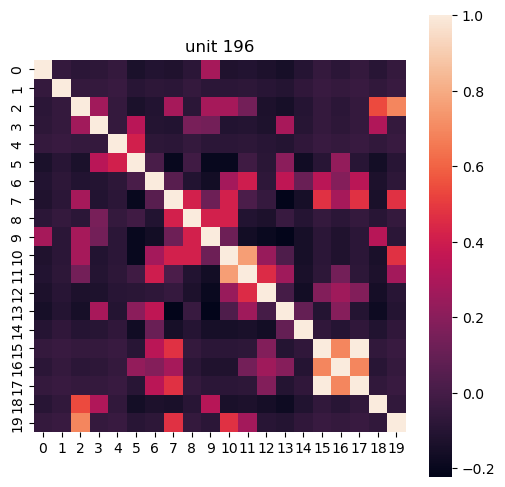

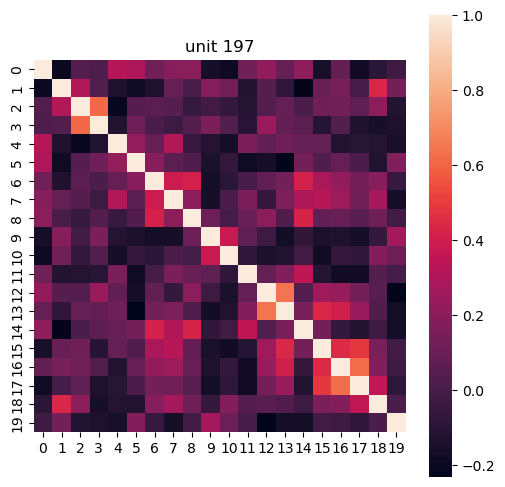

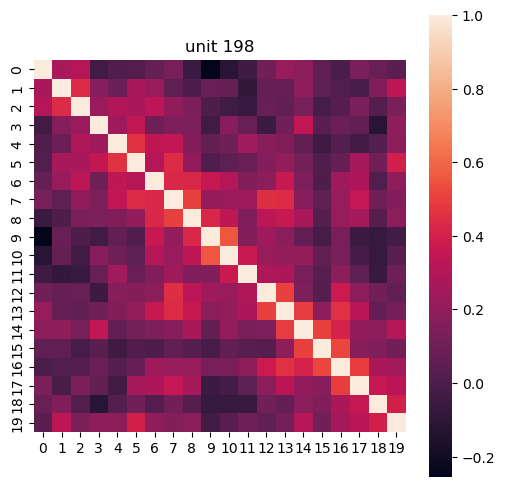

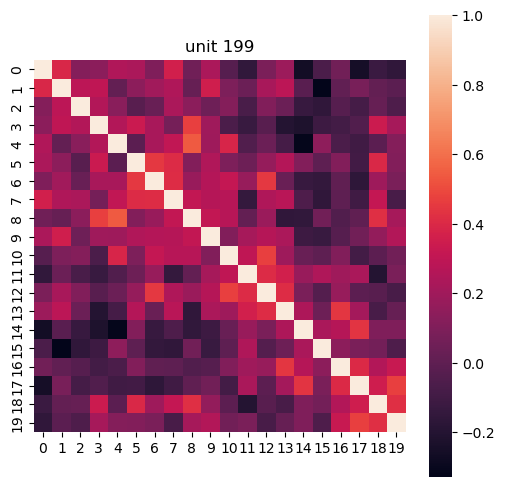

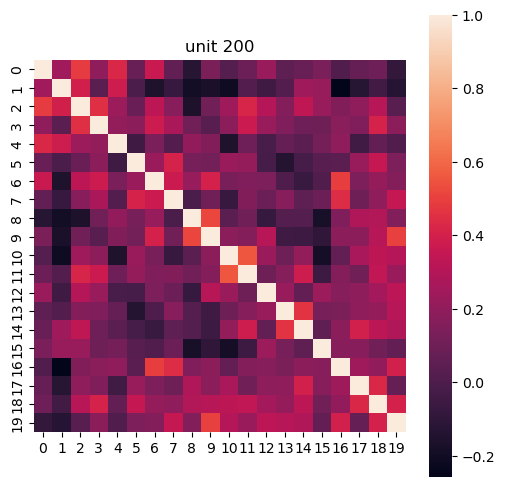

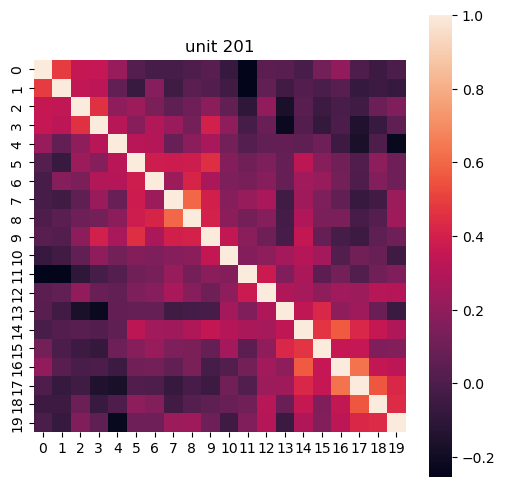

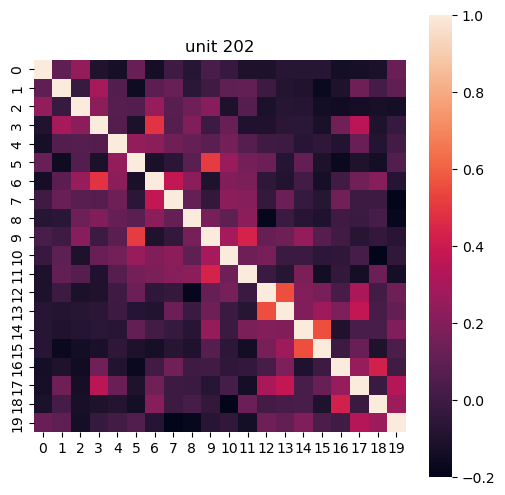

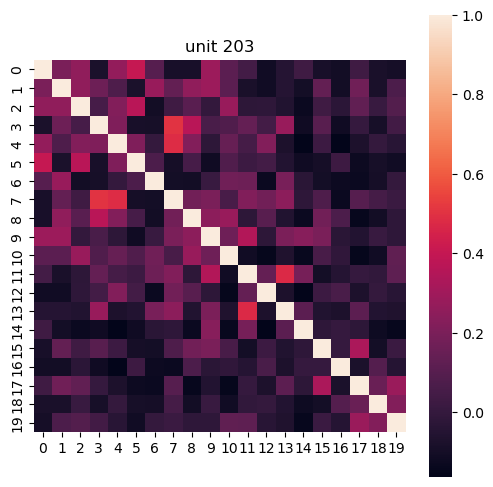

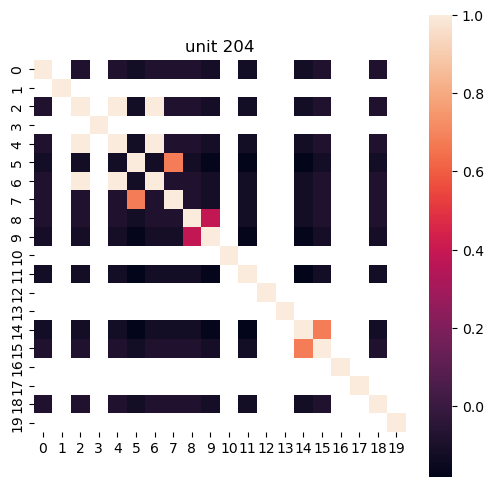

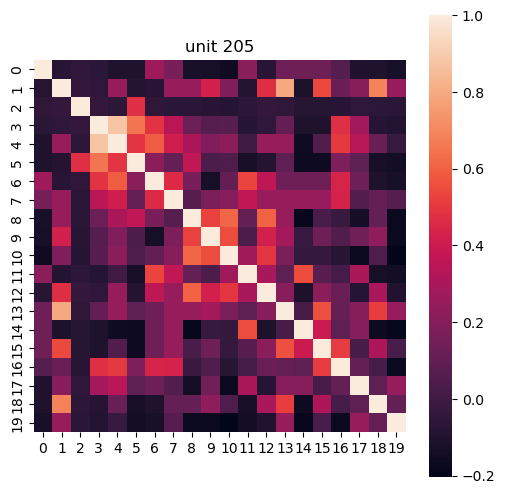

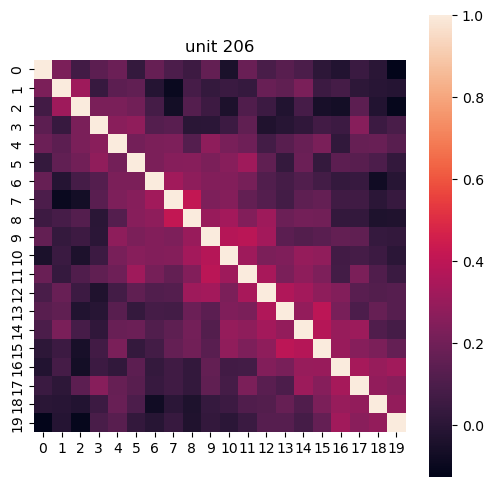

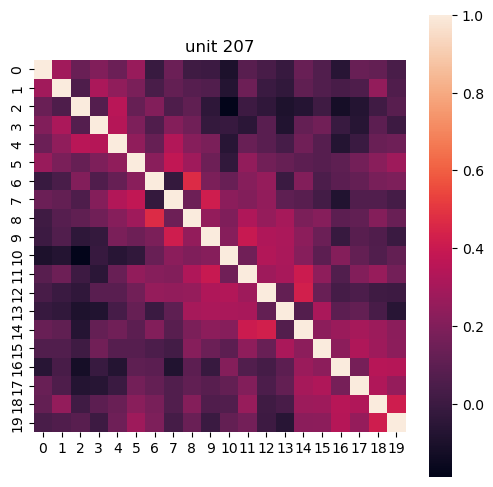

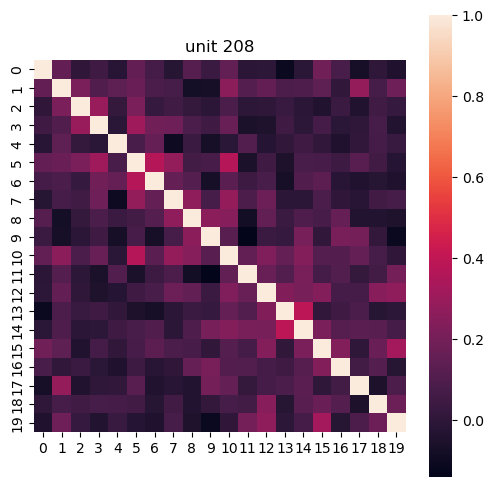

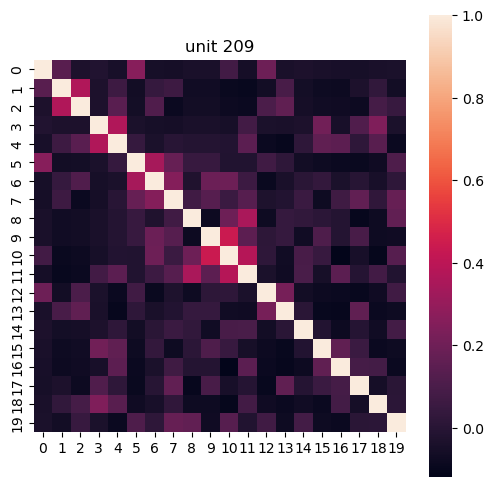

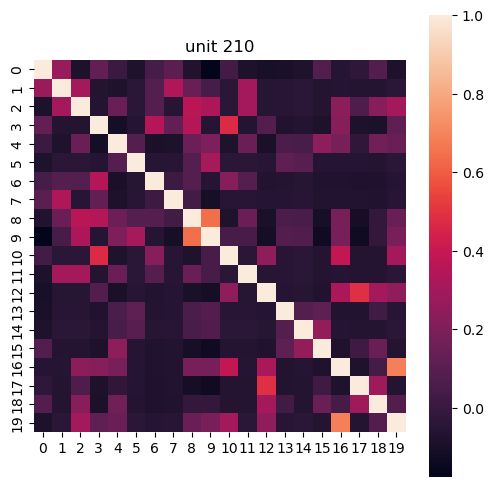

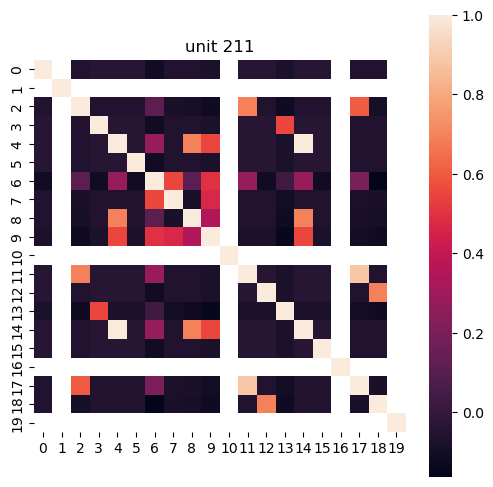

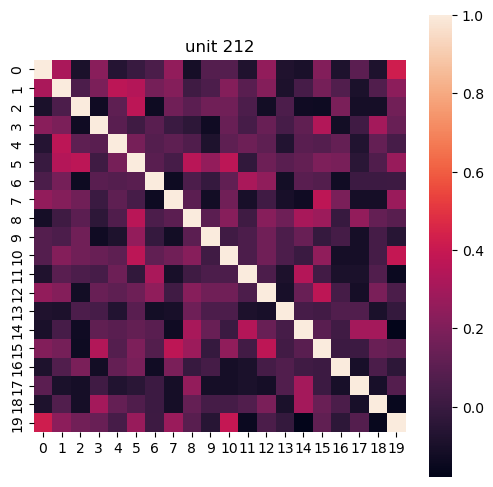

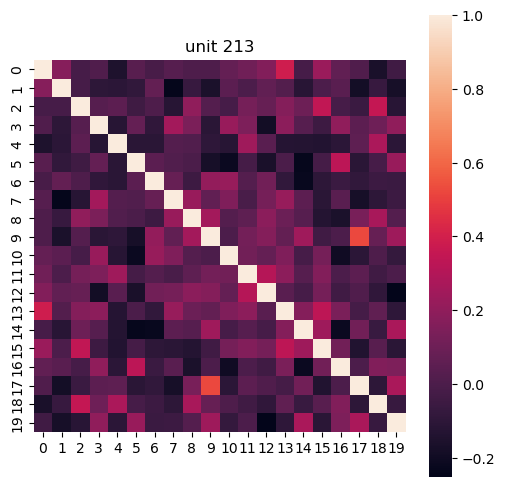

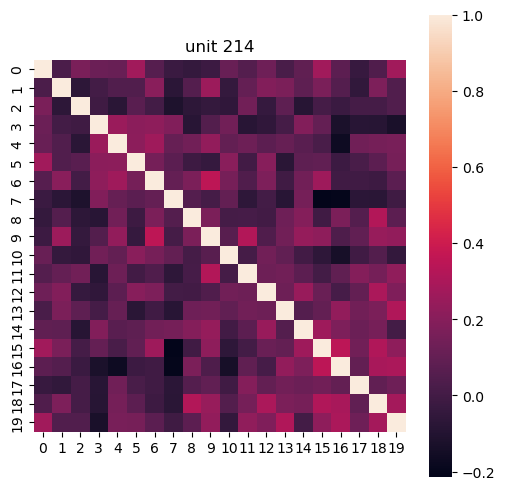

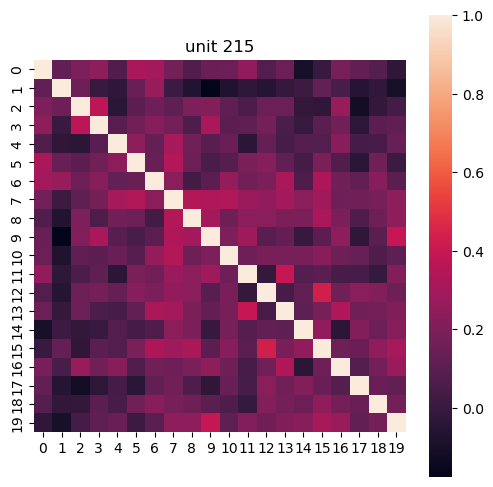

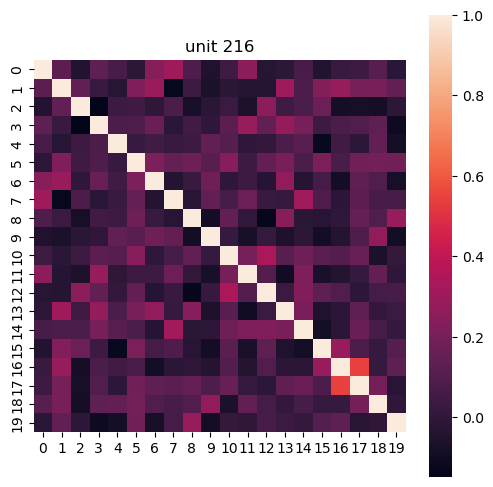

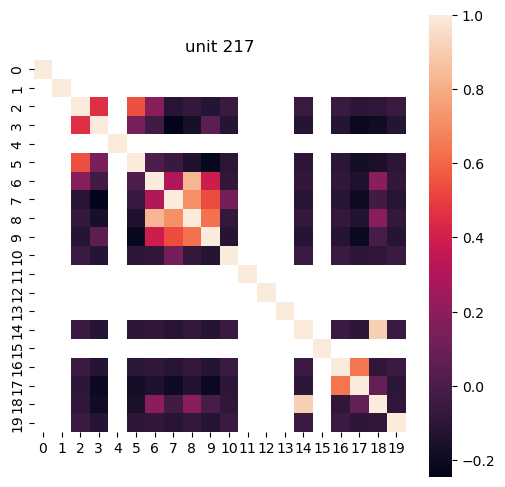

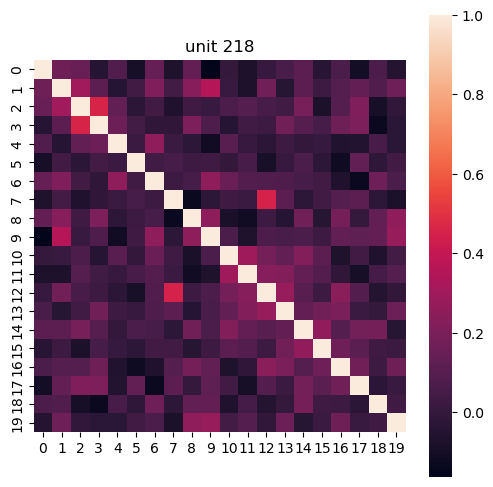

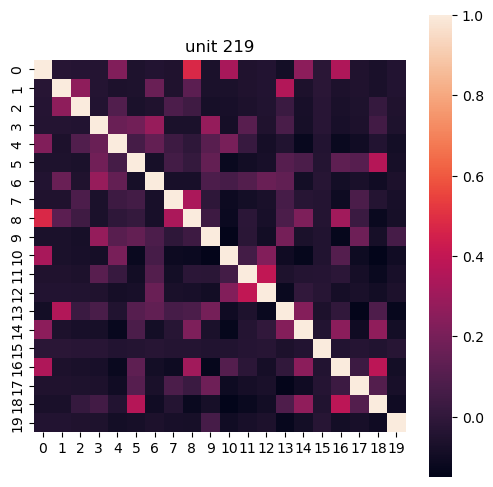

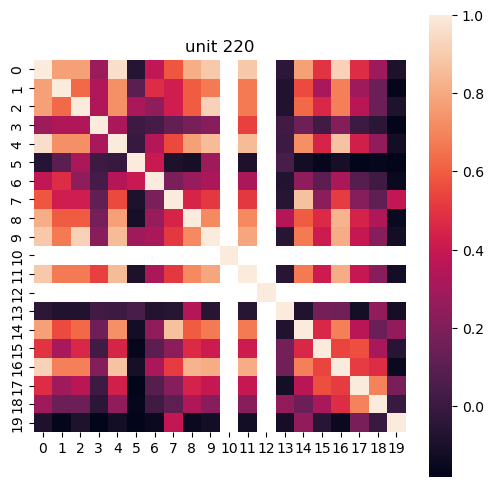

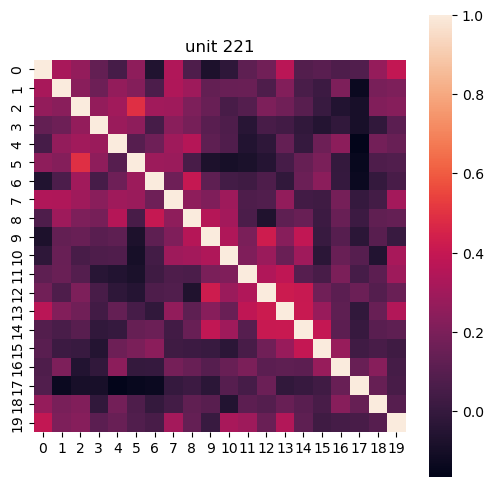

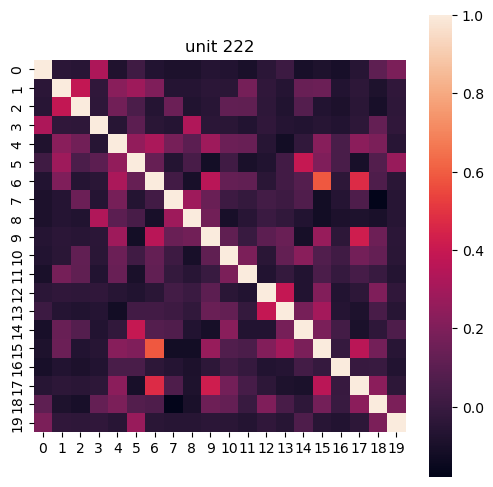

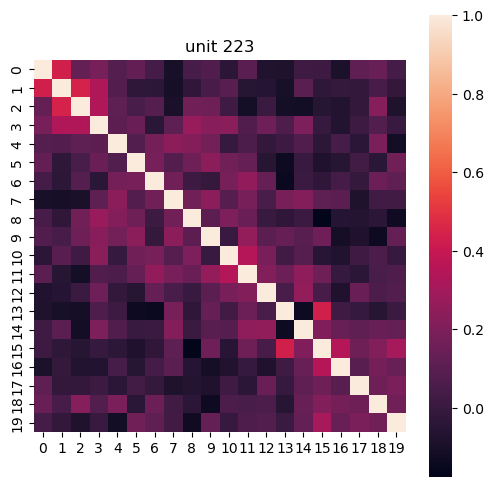

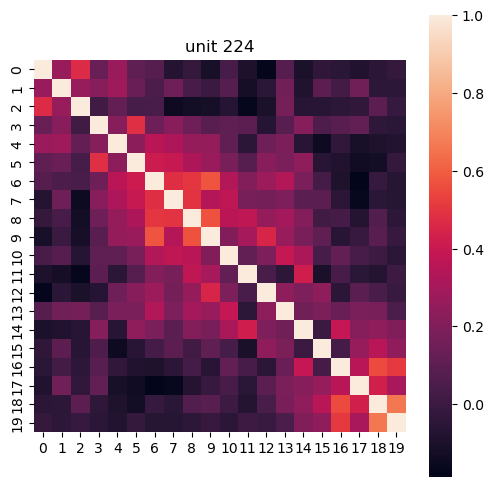

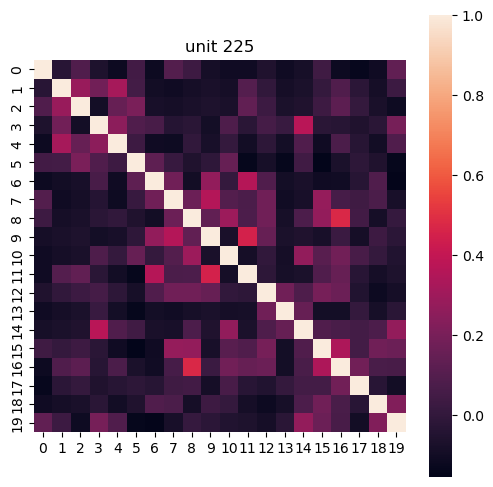

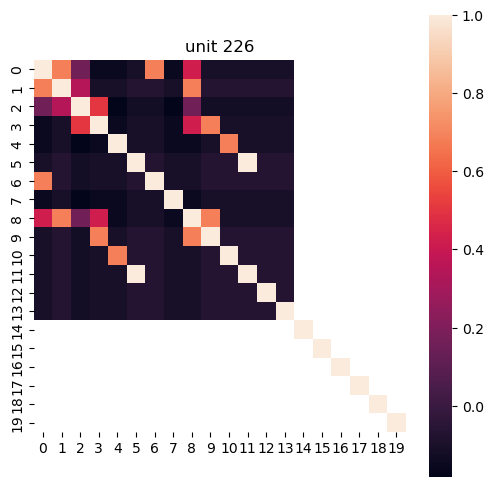

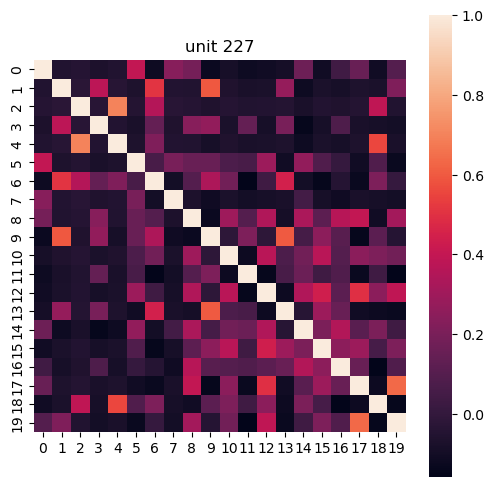

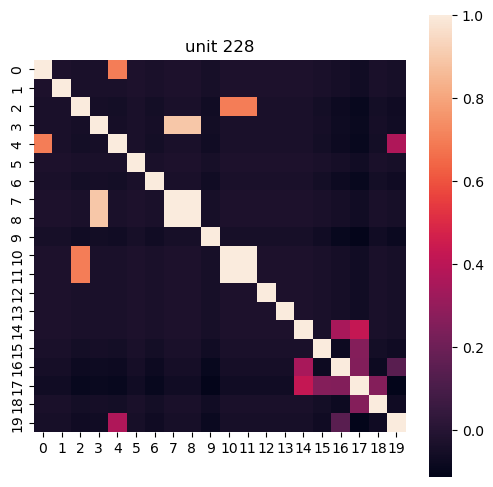

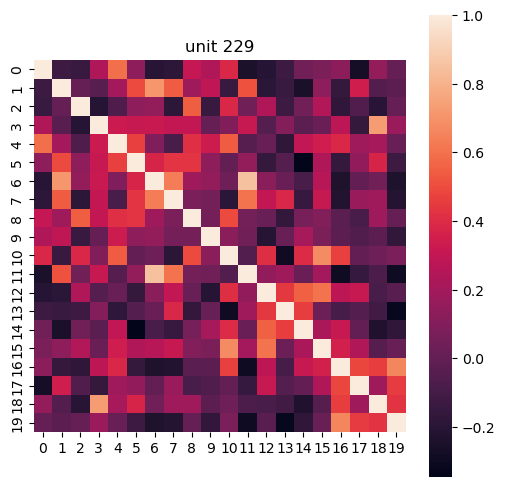

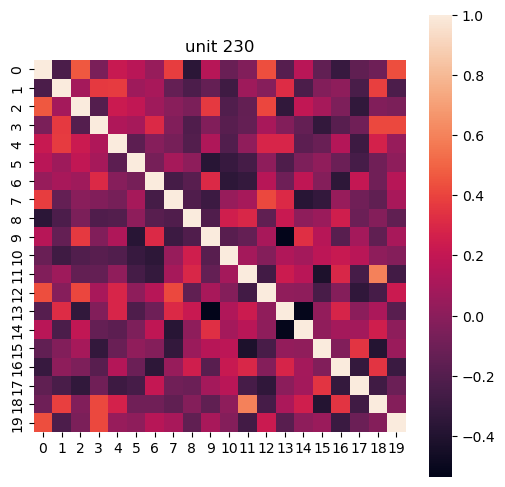

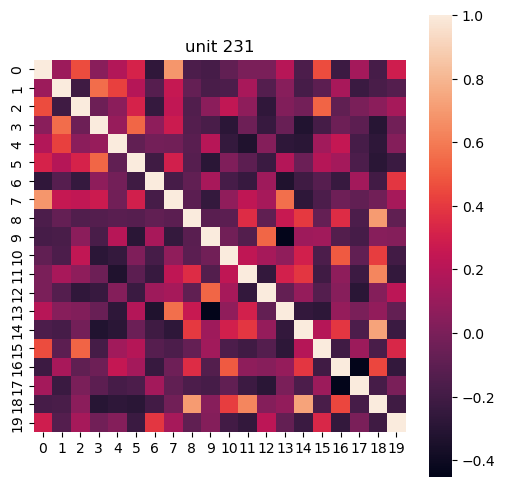

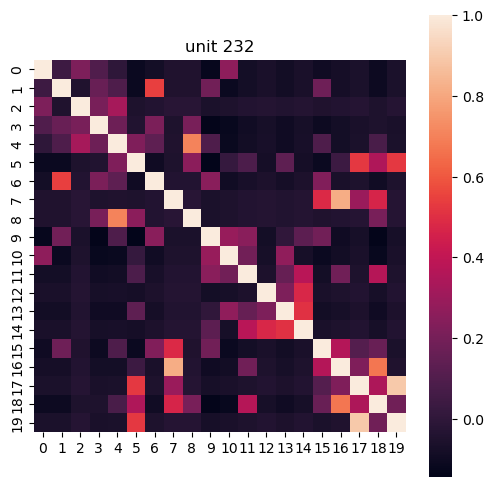

In [ ]:
for idx_, acf_matrix_ in enumerate(acf_matrix_l):
    fig, axes = plt.subplots(1,1,figsize=(6,6))
    acf_matrix_plot = acf_matrix_.T + acf_matrix_
    np.fill_diagonal(acf_matrix_plot, 1)
    sns.heatmap(acf_matrix_plot, ax=axes)
    axes.set_aspect('equal', adjustable='box')
    axes.set_title('unit ' + str(int(acf_average_trial_pearsonr_df.iloc[idx_]['unit_id'])))
    fig.savefig(save_folder + 'acf_matrices\\unit_' + str(int(acf_average_trial_pearsonr_df.iloc[idx_]['unit_id'])), bbox_inches='tight')